# CIS5450 Final Project: Time to Flight...
- Group Members: Linda Shen, Kalen Truong, Charlie Wang

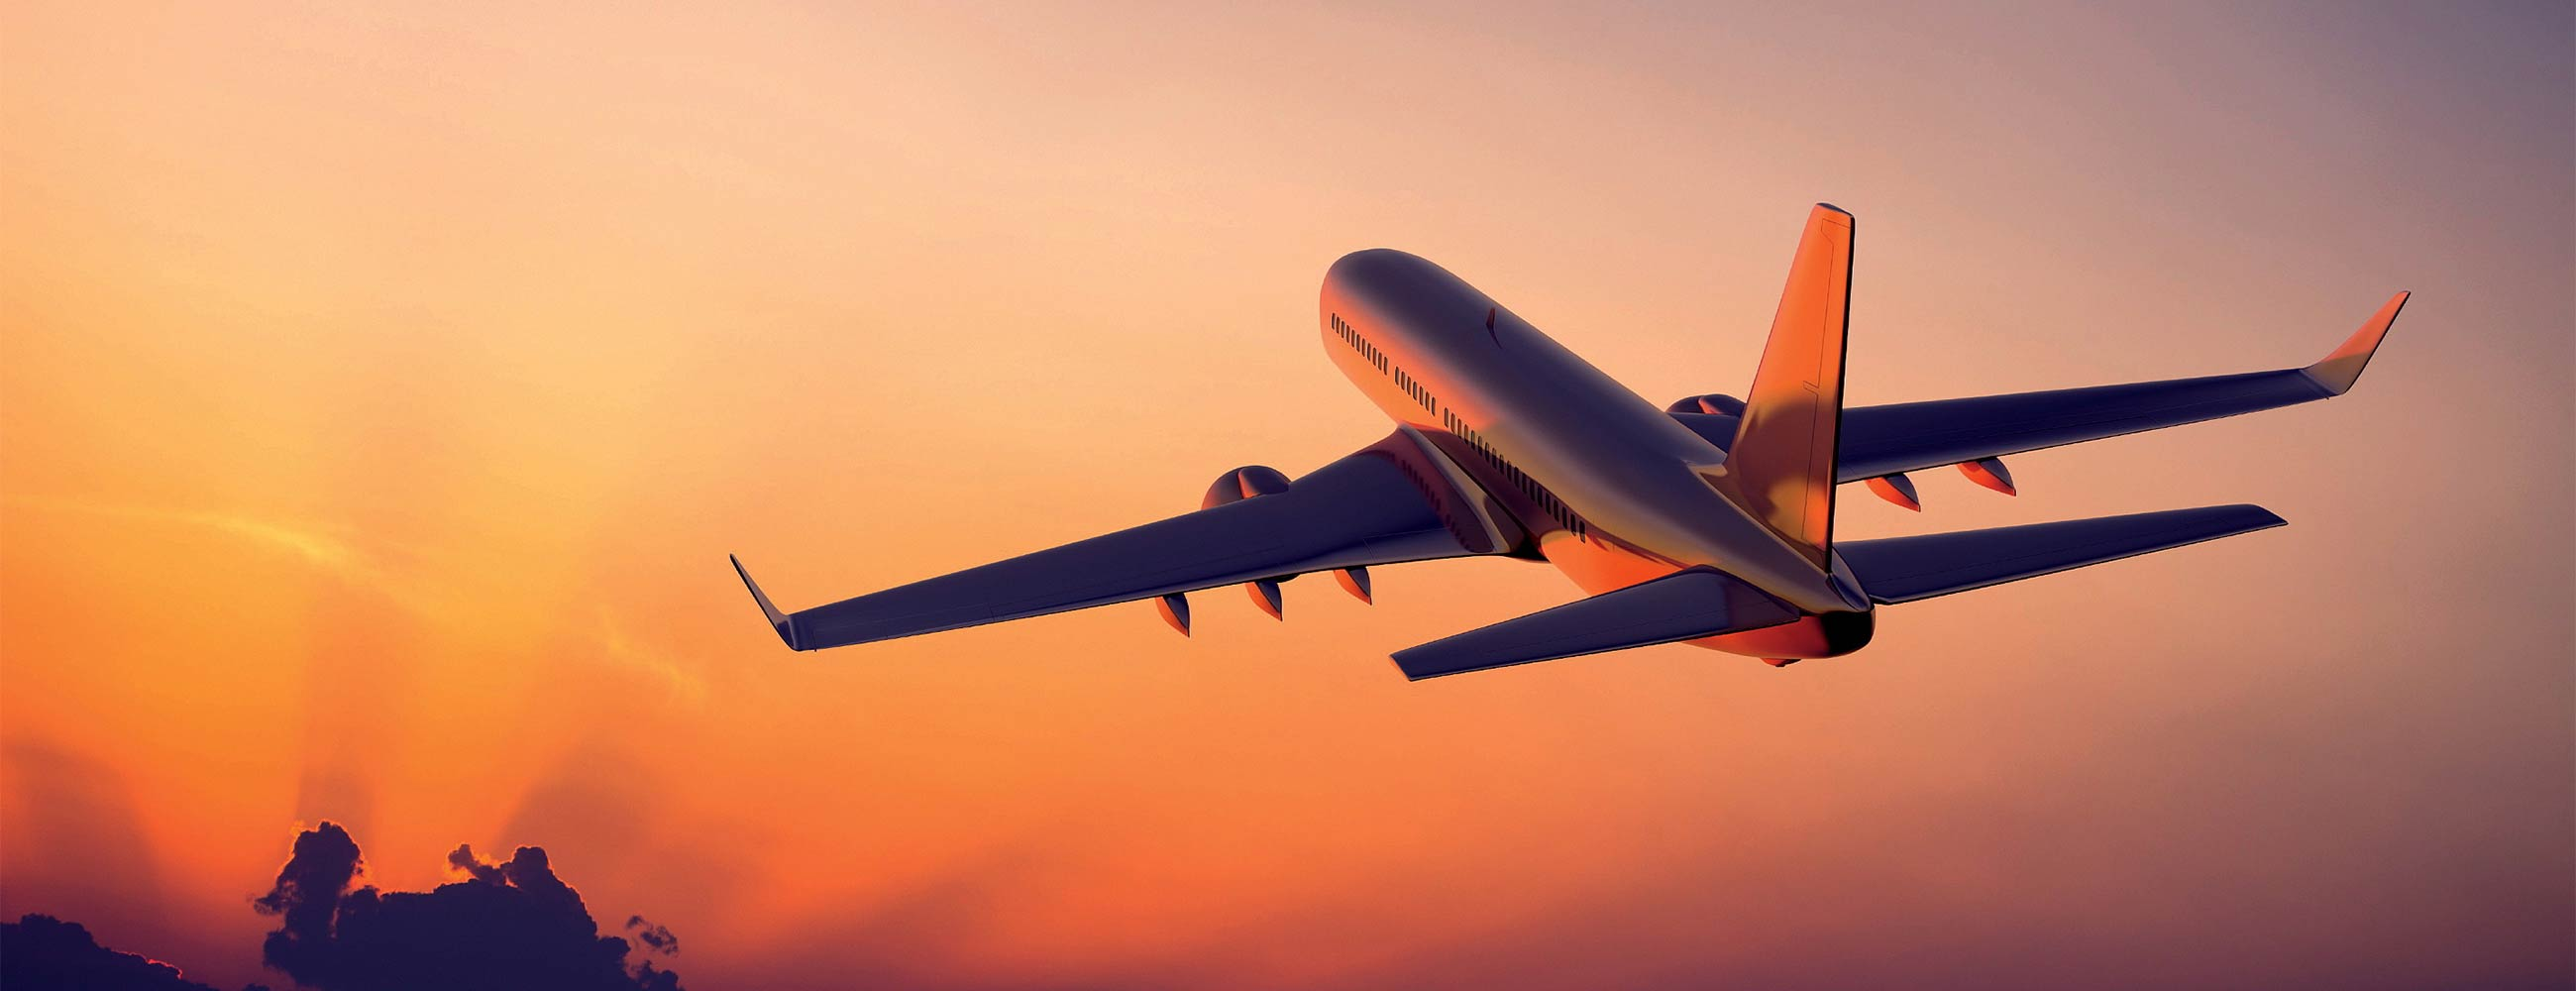


### How did we do this?
- Data Preprocessing: We handled missing values, encoded categorical variables, and made sure that our data was properly formatted for our later analysis.
- EDA: We examined preliminary trends and relationships in our data including the distribution of variables, correlated variables, time-series trends, airline level information and more. We also utilized PCA & KMeans to better understand what factors contribute to variance within our data.

#### Modeling:
- We used classification models to predict flight delays and cancellations (logistic regression, Random Forest, XGBoost)

#### Hypothesis Testing:
There were a lot of questions we had. For our hypothesis tests, here are a few of the questions that were important to consider:
- Do certain airports show statistically significant differences in average delay times?
- Is there a significant different between morning and evening delays?
- Based off of flight duration or distance traveled, is there a significance in the average amount of delays?

#### Challenges
- Data Quality: For pre-processing, we not only had to go through each variable and understand its meaning, but we had to handle missing and ambiguous values.

- Collinearity: Addressing multicollinearity was important to accurately identifiying feature importance.

- Omitted Variables: External factors not captured in the dataset or the subset we created could have also influenced delays.

## Introduction
For our final project, we explored the [Flight Status Prediction](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022/data?select=Combined_Flights_2018.csv) dataset, which contains over 60 columns of data, including flight times, cancellations, and carrier information. Our objective was to predict whether a flight would be delayed or canceled, and to determine the most significant features influencing these outcomes. This is valuable as it could allow us as consumers of flights to better understand what variables contribute to flight delays as this information is often not easily determined. We also aimed to identify the minimum number of features to conduct an effective prediction. This project provided us with valuable insights into the factors influencing flight delays and cancellations, with potential applications in improving airline operations and passenger satisfaction.


# Downloads & Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# flights = flights[["FlightDate", "Airline", "Origin", "Dest", "Cancelled", "Diverted",
#                   "CRSDepTime", "ArrTime", "ArrDelay", "DepTime", "DepDelay",
#                   "AirTime", "Distance", "OriginCityName", "DestCityName",
#                   "Tail_Number"]]
# flights.to_csv("combined_subset_16.csv")

# Data Pre-Processing

In [ ]:
# Read in the dataset, save it to a dataframe called 'flights'
flights = pd.read_csv('/content/drive/MyDrive/Combined_Flights_2022.csv')
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078318 entries, 0 to 4078317
Data columns (total 61 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   FlightDate                               object 
 1   Airline                                  object 
 2   Origin                                   object 
 3   Dest                                     object 
 4   Cancelled                                bool   
 5   Diverted                                 bool   
 6   CRSDepTime                               int64  
 7   DepTime                                  float64
 8   DepDelayMinutes                          float64
 9   DepDelay                                 float64
 10  ArrTime                                  float64
 11  ArrDelayMinutes                          float64
 12  AirTime                                  float64
 13  CRSElapsedTime                           float64
 14  ActualElapsedTime 

The 2022 Flight Status Prediction [dataset](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022/data?select=Combined_Flights_2022.csv) on Kaggle has 61 features with a variety of input types (int, text, float, booleans, etc.) and over 4 million rows of data. For our initial problem, we decided to choose a select subset of 16 features to reduce complexity and gather semantical meaning. The features selected are listed below:

```
# "FlightDate", "Airline", "Origin", "Dest", "Cancelled", "Diverted",
# "CRSDepTime", "ArrTime", "ArrDelay", "DepTime", "DepDelay",
# "AirTime", "Distance", "OriginCityName", "DestCityName",
# "Tail_Number"
```

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/combined_subset_16.csv", index_col=0)

## Cleaning up raw data source

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4078318 entries, 0 to 4078317
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   FlightDate      object 
 1   Airline         object 
 2   Origin          object 
 3   Dest            object 
 4   Cancelled       bool   
 5   Diverted        bool   
 6   CRSDepTime      int64  
 7   ArrTime         float64
 8   ArrDelay        float64
 9   DepTime         float64
 10  DepDelay        float64
 11  AirTime         float64
 12  Distance        float64
 13  OriginCityName  object 
 14  DestCityName    object 
 15  Tail_Number     object 
dtypes: bool(2), float64(6), int64(1), object(7)
memory usage: 474.5+ MB


In [ ]:
columns = df.columns
print(df.shape)
df.describe()

(4078318, 16)


,CRSDepTime,ArrTime,ArrDelay,DepTime,DepDelay,AirTime,Distance
count,4.078318e+06,3.954079e+06,3.944916e+06,3.957885e+06,3.957823e+06,3.944916e+06,4.078318e+06
mean,1.329587e+03,1.457886e+03,7.528486e+00,1.334374e+03,1.309049e+01,1.110075e+02,7.978657e+02
std,4.904801e+02,5.431841e+02,5.524625e+01,5.056219e+02,5.332016e+01,6.996246e+01,5.914742e+02
min,1.000000e+00,1.000000e+00,-1.000000e+02,1.000000e+00,-7.800000e+01,8.000000e+00,3.100000e+01
25%,9.140000e+02,1.046000e+03,-1.400000e+01,9.170000e+02,-5.000000e+00,6.000000e+01,3.680000e+02
50%,1.320000e+03,1.500000e+03,-5.000000e+00,1.325000e+03,-2.000000e+00,9.400000e+01,6.430000e+02
75%,1.735000e+03,1.914000e+03,1.000000e+01,1.744000e+03,1.100000e+01,1.410000e+02,1.035000e+03
max,2.359000e+03,2.400000e+03,7.232000e+03,2.400000e+03,7.223000e+03,7.270000e+02,5.095000e+03


Let's drop the duplicates and nulls

In [ ]:
# drop duplicates and nulls
print("original # of rows:", len(df))
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print("# of rows after dropping NaNs and duplicates:", len(df))

original # of rows: 4078318
# of rows after dropping NaNs and duplicates: 3944916


## Encoding

In this section, we looked for all categorical data (typically strings) with more than two values. This gives us a subset of features called `unordered_features` which we will soon encode.

In [ ]:
unordered_features = []
uncleaned_df = df.copy()
for column in uncleaned_df.columns:
  if uncleaned_df[column].nunique() > 2 and uncleaned_df[column].dtype == 'object':
    unordered_features.append(column)
unordered_features

['FlightDate',
 'Airline',
 'Origin',
 'Dest',
 'OriginCityName',
 'DestCityName',
 'Tail_Number']

In [ ]:
for column in unordered_features:
  print(column, uncleaned_df[column].nunique())

FlightDate 212
Airline 21
Origin 375
Dest 375
OriginCityName 369
DestCityName 369
Tail_Number 5893


In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoded_df = df.copy()
local_mapping = {}
for feature in unordered_features:
  encoder = LabelEncoder()
  encoded_df[feature] = encoder.fit_transform(encoded_df[feature])

  # store the mapping
  local_mapping[feature] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_).astype(int)))
  # print(local_mapping[feature])
encoded_df

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,ArrTime,ArrDelay,DepTime,DepDelay,AirTime,Distance,OriginCityName,DestCityName,Tail_Number
0,93,6,141,97,False,False,1133,1228.0,-17.0,1123.0,-10.0,40.0,212.0,127,87,752
1,93,6,164,171,False,False,732,848.0,-1.0,728.0,-4.0,55.0,295.0,140,152,487
2,93,6,103,97,False,False,1529,1636.0,-3.0,1514.0,-15.0,47.0,251.0,97,87,752
3,93,6,171,143,False,False,1435,1547.0,-18.0,1430.0,-5.0,57.0,376.0,152,135,177
4,93,6,103,97,False,False,1135,1251.0,6.0,1135.0,0.0,49.0,251.0,97,87,534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944911,89,16,122,121,False,False,1617,2256.0,207.0,1953.0,216.0,152.0,1196.0,175,236,3312
3944912,89,16,73,121,False,False,1418,1930.0,201.0,1801.0,223.0,65.0,404.0,68,236,3319
3944913,89,16,169,276,False,False,1750,2201.0,180.0,2105.0,195.0,37.0,182.0,351,264,3281
3944914,77,16,121,223,False,False,2035,52.0,135.0,2309.0,154.0,144.0,946.0,236,212,3720


After doing more analysis, we noticed that after dropping null values, the Cancelled and the Diverted features all have one value (False) and made the decision to remove them from our subset as it would not contribute to meaningful information.

In [ ]:
single_values = []
for column in encoded_df.columns:
  if encoded_df[column].nunique() <= 1:
    single_values.append(column)
single_values

['Cancelled', 'Diverted']

In [ ]:
encoded_df = encoded_df.drop(columns=single_values)
encoded_df.shape
df = df.drop(columns=single_values)

# Exploratory Data Analysis (EDA)

After data preprocessing, we now move on to EDA! First thing we wanted to see is how distributed our data and so we first moved onto data visualization of our features.


## Distribution of Our Dataset

In [ ]:
for column in encoded_df:
  print(column, encoded_df[column].nunique())

FlightDate 212
Airline 21
Origin 375
Dest 375
CRSDepTime 1320
ArrTime 1440
ArrDelay 1641
DepTime 1440
DepDelay 1604
AirTime 666
Distance 1578
OriginCityName 369
DestCityName 369
Tail_Number 5893


In [ ]:
visualize_df = df.copy()

We look at the distribution of `"FlightDate" (by month), "Airline", "Distance", and "AirTime"`.

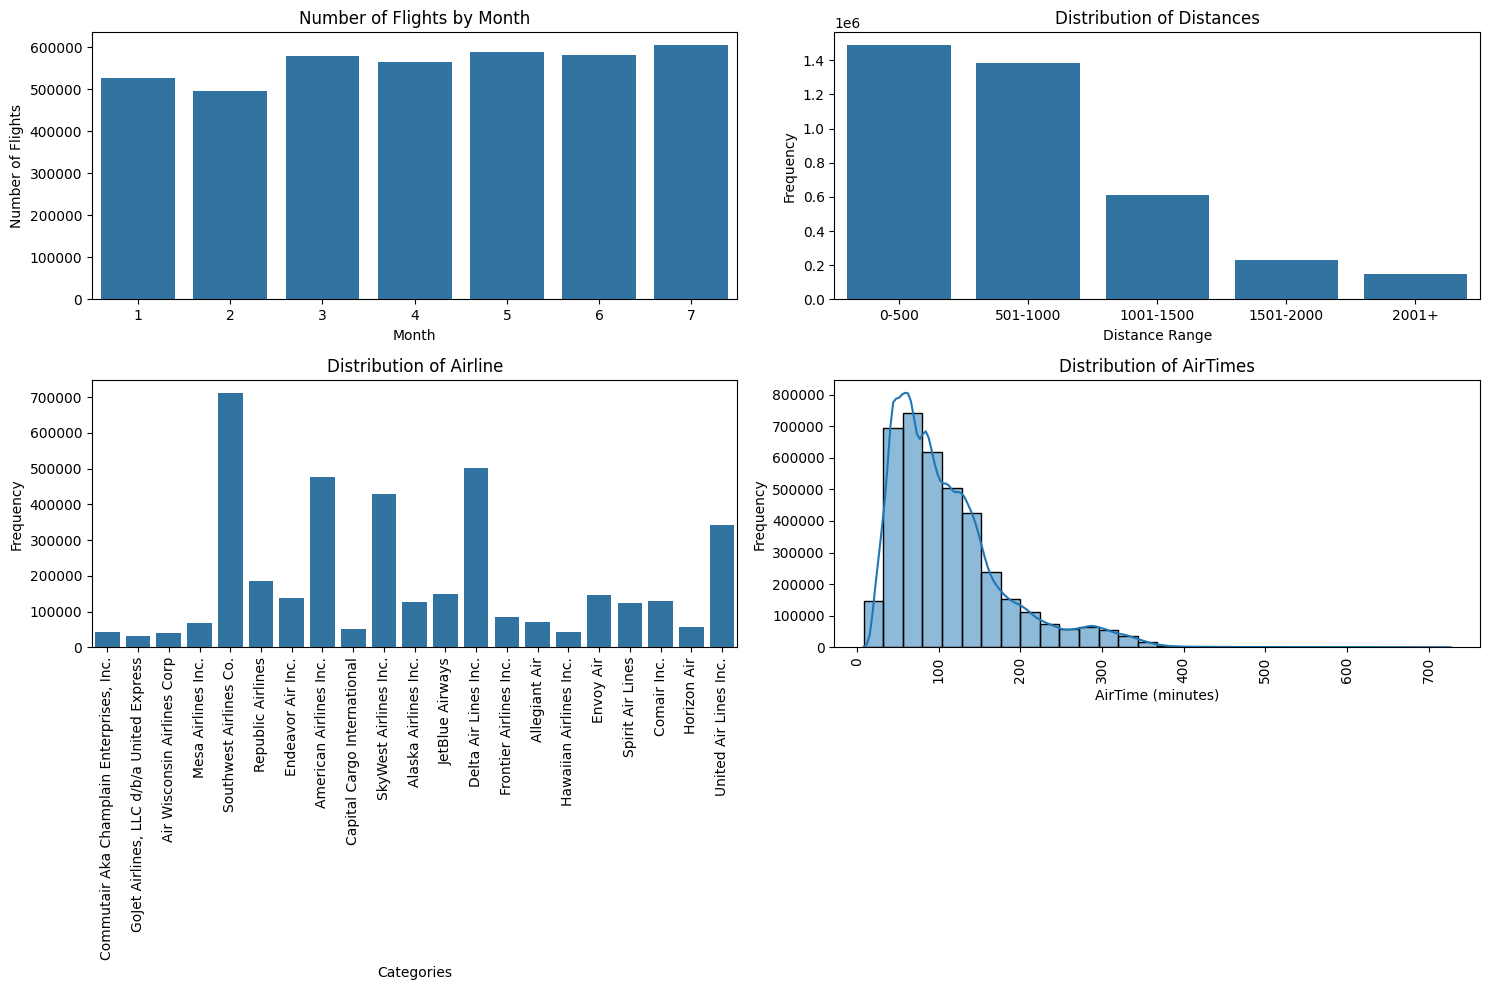

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
# FlightDate, by month
visualize_df['Month'] = pd.to_datetime(visualize_df['FlightDate']).dt.month
flights_by_month = visualize_df.groupby('Month')['FlightDate'].count()
sns.barplot(x=flights_by_month.index, y=flights_by_month.values, ax=axes[0])
axes[0].set_title('Number of Flights by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Flights')

# Distance (by bins)
visualize_df['Distance_Bins'] = pd.cut(encoded_df['Distance'], bins=[0, 500, 1000, 1500, 2000, 2500], labels=['0-500', '501-1000', '1001-1500', '1501-2000', '2001+'])
distance_counts = visualize_df['Distance_Bins'].value_counts().sort_index()
sns.barplot(x= distance_counts.index, y=distance_counts.values, ax=axes[1])
axes[1].set_title('Distribution of Distances')
axes[1].set_xlabel('Distance Range')
axes[1].set_ylabel('Frequency')

# Airline
sns.countplot(x=visualize_df["Airline"], ax=axes[2])
axes[2].set_title(f'Distribution of Airline')
axes[2].set_xlabel('Categories')
axes[2].set_ylabel('Frequency')
axes[2].tick_params(axis='x', rotation=90)

# AirTime
sns.histplot(x=visualize_df["AirTime"], bins=30, kde=True, ax=axes[3])
axes[3].set_title('Distribution of AirTimes')
axes[3].set_xlabel('AirTime (minutes)')
axes[3].set_ylabel('Frequency')
axes[3].tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()

For the features `("Origin", "Dest"), ("OriginCityName", "DestCityName")`, we choose to choose the top 10. We can see these features are very similar!

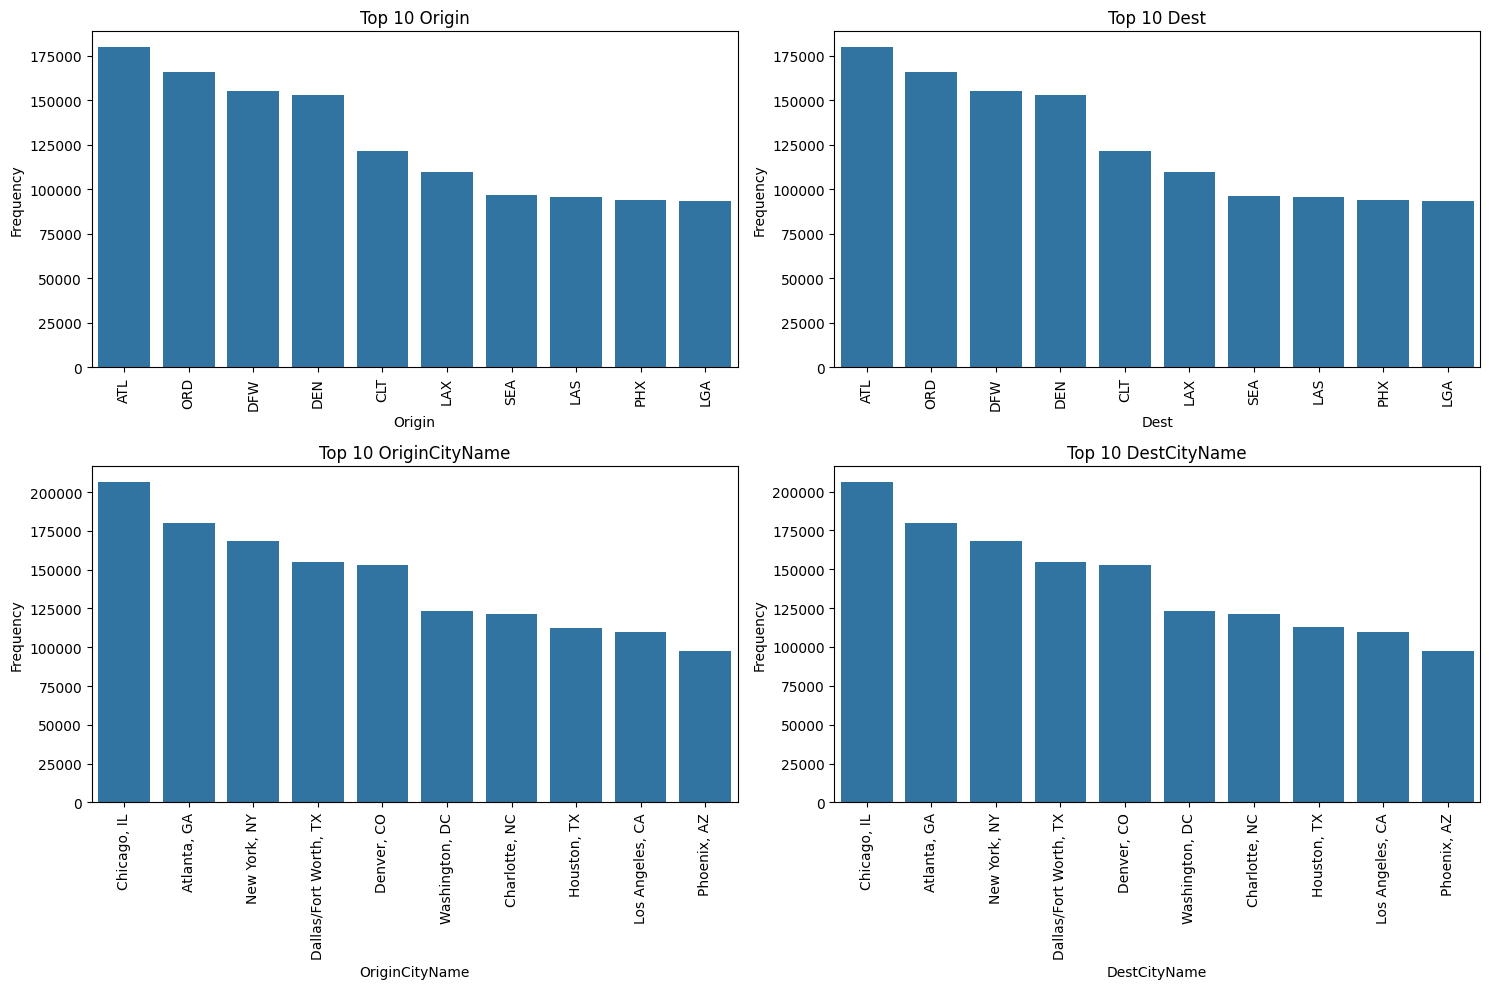

In [ ]:
# Locations
locations = ["Origin", "Dest", "OriginCityName", "DestCityName"]
top_10_dests = visualize_df[locations]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, location in enumerate(locations):
    top_10 = top_10_dests[location].value_counts().nlargest(10).index
    sns.countplot(x=location, data=top_10_dests, order=top_10, ax=axes[i])
    axes[i].set_title(f'Top 10 {location}')
    axes[i].set_xlabel(location)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Lastly, for the 6 remaining features,

`"CRSDepTime", "ArrTime", "ArrDelay", "DepTime", "DepDelay", "Tail_Number"`,

we use a histogram to visualize how time is distributed. Tail Number is categorical and is hard to visualize all 5893 different types of airplane objects

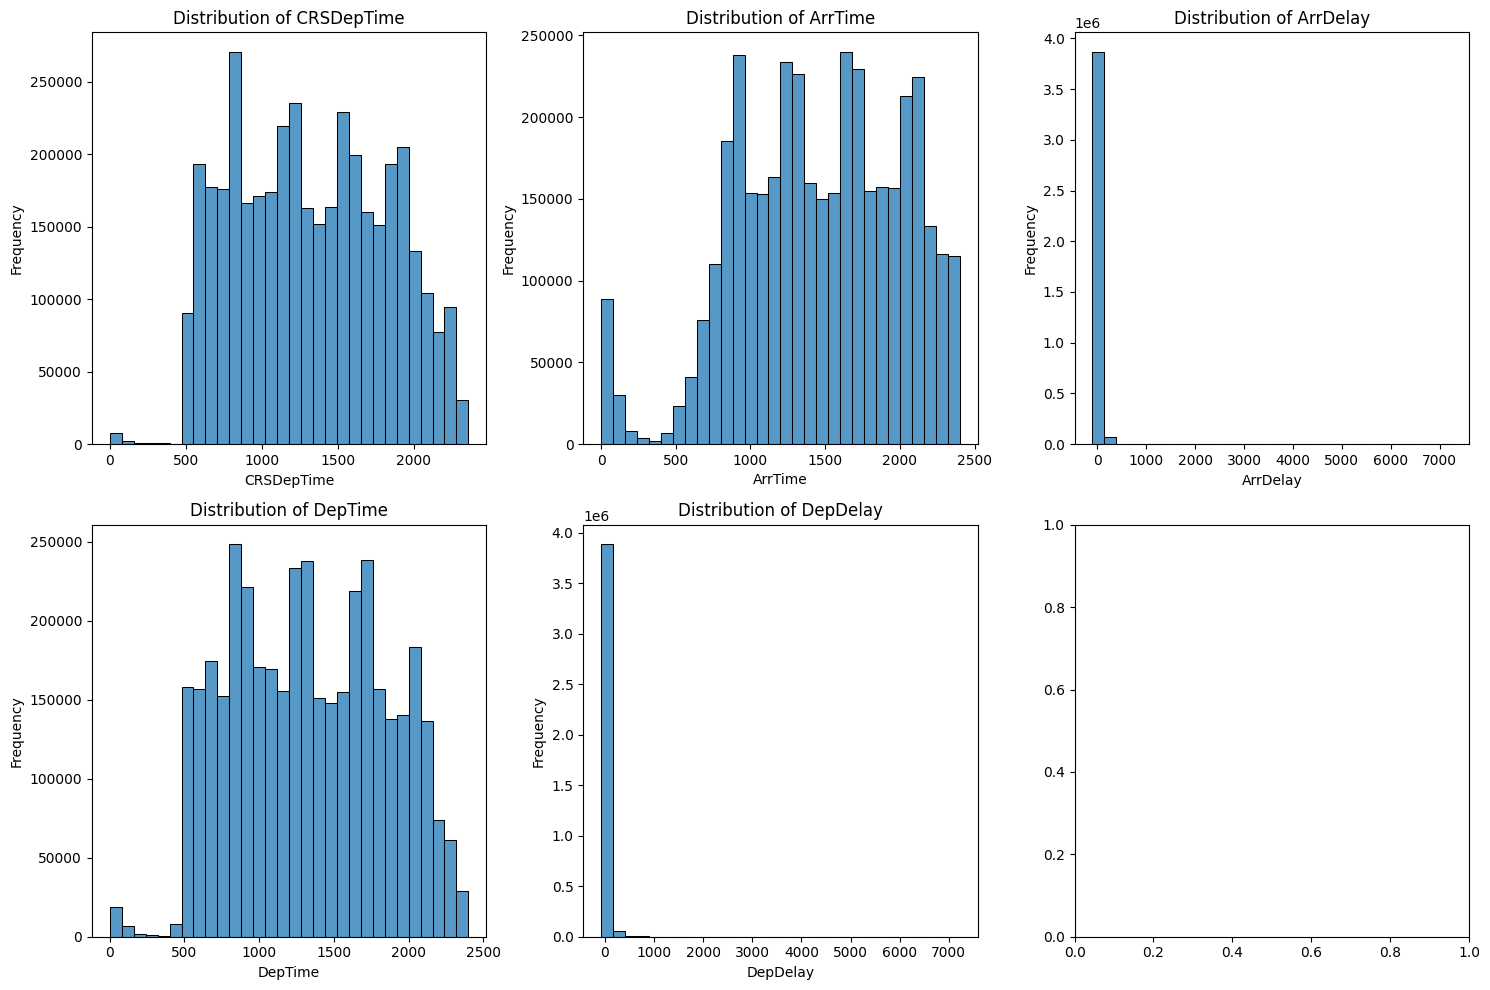

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

time_tail_features = ["CRSDepTime", "ArrTime", "ArrDelay",
                      "DepTime", "DepDelay"]
# ["Tail_Number"]

for i, feature in enumerate(time_tail_features):
    # print("I:", i)
    sns.histplot(x=visualize_df[feature], bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Saved another csv file as another checkpoint.

In [ ]:
encoded_df.to_csv('cleaned_flights_df.csv')

In addition, we explored some potential questions and plotted them below.

In [ ]:
# sample form df (analysis_df has the encoding and we cannot group by months.)
analyze_df = df.copy().sample(n=100000, random_state=42)
analyze_df.head()

,FlightDate,Airline,Origin,Dest,CRSDepTime,ArrTime,ArrDelay,DepTime,DepDelay,AirTime,Distance,OriginCityName,DestCityName,Tail_Number
1017783,2022-02-23,United Air Lines Inc.,EWR,SEA,705,1006.0,-8.0,703.0,-2.0,333.0,2402.0,"Newark, NJ","Seattle, WA",N37255
1094138,2022-07-13,SkyWest Airlines Inc.,IDA,DFW,1345,1759.0,21.0,1352.0,7.0,132.0,1095.0,"Idaho Falls, ID","Dallas/Fort Worth, TX",N701SK
327163,2022-04-19,Delta Air Lines Inc.,SEA,SAN,1925,2221.0,12.0,1927.0,2.0,134.0,1050.0,"Seattle, WA","San Diego, CA",N385DN
1878958,2022-05-05,American Airlines Inc.,CLT,BDL,1102,1303.0,5.0,1111.0,9.0,86.0,644.0,"Charlotte, NC","Hartford, CT",N121UW
783405,2022-02-16,Alaska Airlines Inc.,SEA,TPA,755,1558.0,-12.0,751.0,-4.0,281.0,2520.0,"Seattle, WA","Tampa, FL",N275AK


## What's the correlation between DepDelay and ArrDelay?

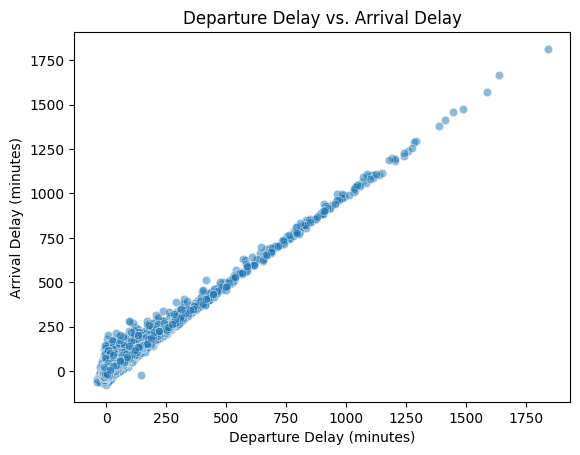

In [ ]:
sns.scatterplot(x=analyze_df['DepDelay'], y=analyze_df['ArrDelay'], alpha=0.5)
plt.title('Departure Delay vs. Arrival Delay')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.show()

## Mean delay by month

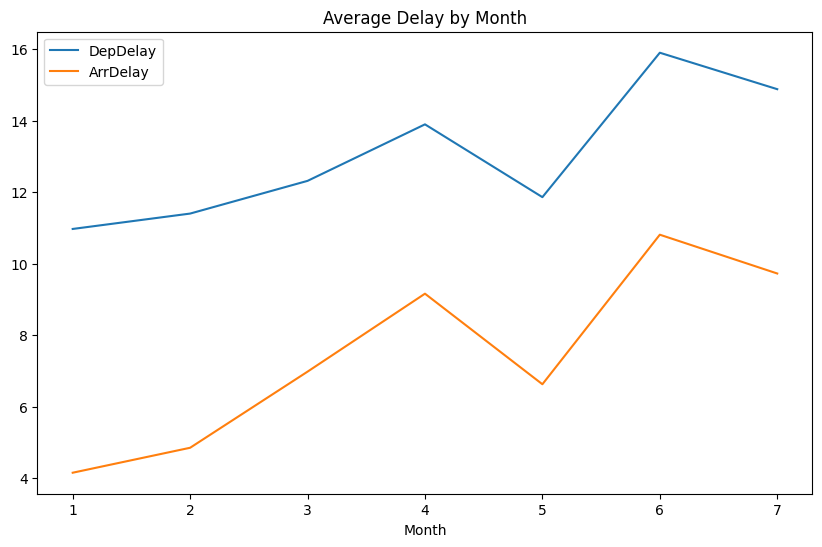

In [ ]:
# Mean delay by month
analyze_df['Month'] = pd.to_datetime(analyze_df['FlightDate']).dt.month
delay_by_month = analyze_df.groupby('Month')[['DepDelay', 'ArrDelay']].mean()
delay_by_month.plot(kind='line', figsize=(10, 6), title='Average Delay by Month')
plt.show()

## Which airline has the most flights?

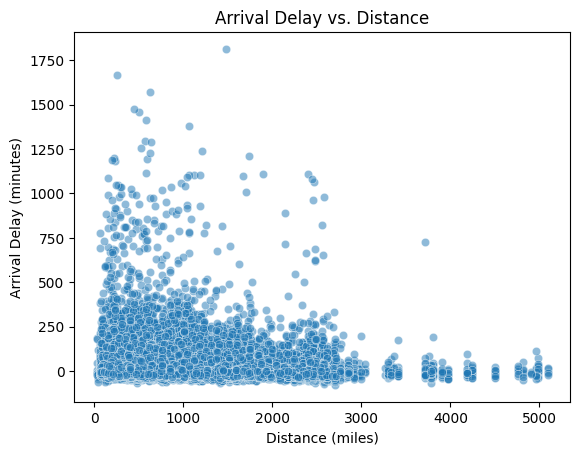

In [ ]:
# Scatter plot of delays vs distance
sns.scatterplot(x=analyze_df['Distance'], y=analyze_df['ArrDelay'], alpha=0.5)
plt.title('Arrival Delay vs. Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Arrival Delay (minutes)')
plt.show()

## Find Insights on Avg. Flight Delays on an Hourly Basis

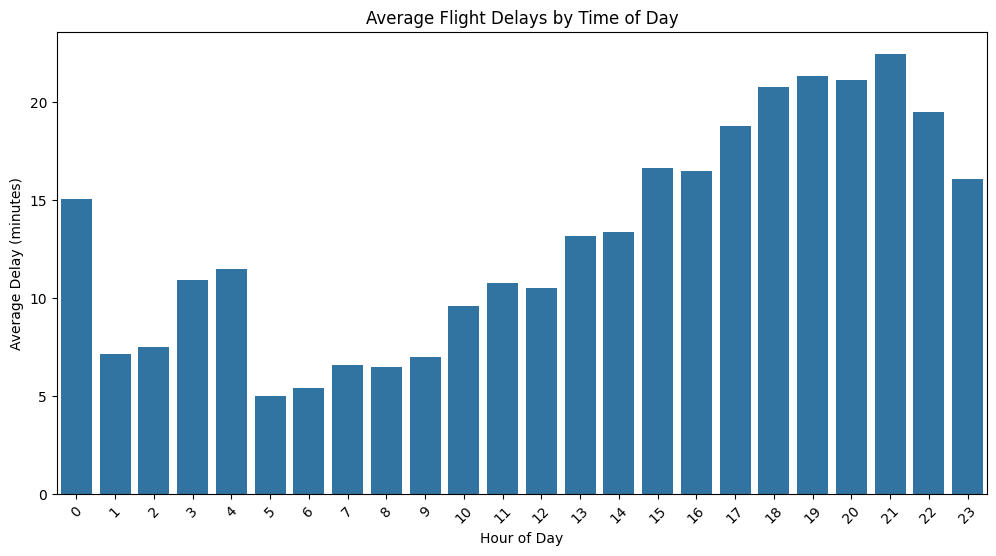

In [ ]:
flights = analyze_df.copy()
# convert CRSDepTime to hours
flights['DepHour'] = flights['CRSDepTime'] // 100

# get average delay by hour
average_delays_by_hour = flights.groupby('DepHour')['DepDelay'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=average_delays_by_hour, x='DepHour', y='DepDelay')
plt.title('Average Flight Delays by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45)
plt.show()

From the plot above, we see that flights experience higher average delays later in the day, with delays gradually increasing from the early afternoon hours and peaking in the evening.
- Early morning flights show lower average delays, suggesting that flying earlier might reduce the likelihood of encountering delays

<ipython-input-25-053e6e24d61e>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delays_by_type = flights.groupby('FlightType')['DepDelay'].mean()


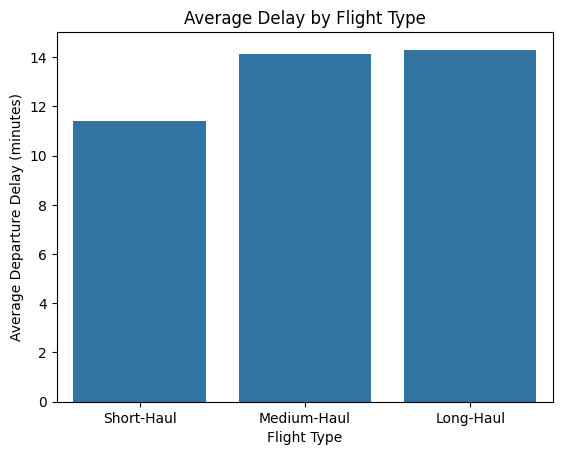

In [ ]:
flights['FlightType'] = pd.cut(flights['Distance'], bins=[0, 500, 1500, float('inf')],
                               labels=['Short-Haul', 'Medium-Haul', 'Long-Haul'])
delays_by_type = flights.groupby('FlightType')['DepDelay'].mean()

sns.barplot(x=delays_by_type.index, y=delays_by_type)
plt.title('Average Delay by Flight Type')
plt.xlabel('Flight Type')
plt.ylabel('Average Departure Delay (minutes)')
plt.show()

Based off of these findings, we see that short-haul flights (flights covering short distances) experience the lowest average delay. Medium and long haul flights have similar average departure delays, which is higher compared to short haul. Overall, medium and long-haul flights tend to have higher departure delays.

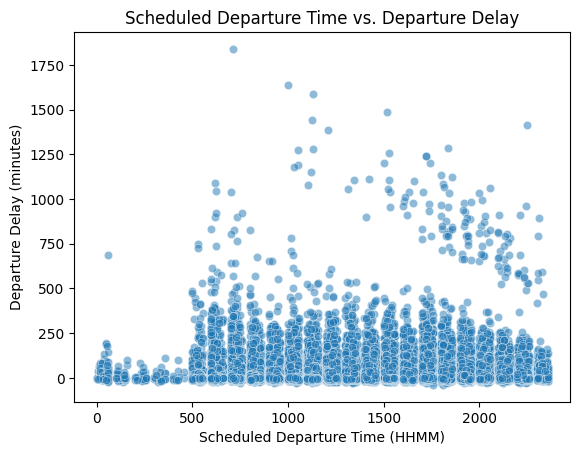

In [ ]:
sns.scatterplot(x=flights['CRSDepTime'], y=flights['DepDelay'], alpha=0.5)
plt.title('Scheduled Departure Time vs. Departure Delay')
plt.xlabel('Scheduled Departure Time (HHMM)')
plt.ylabel('Departure Delay (minutes)')
plt.show()

This shows the relationship between scheduled departure times and departure delays. Most delays are clustered at lower values but can spike to extreme outliers regardless of the departure time. There doesn't appear to be a strong, consistent pattern between scheduled time and delay, though certain time periods (e.g., like in the middle day) might have more variability in delays.

## Correlation Matrix

With the visualization of our features, we gathered some relevant insights. The similarities we saw between features (DepTime and CRSDepTime) were verified with the visualization of the correlation matrix.

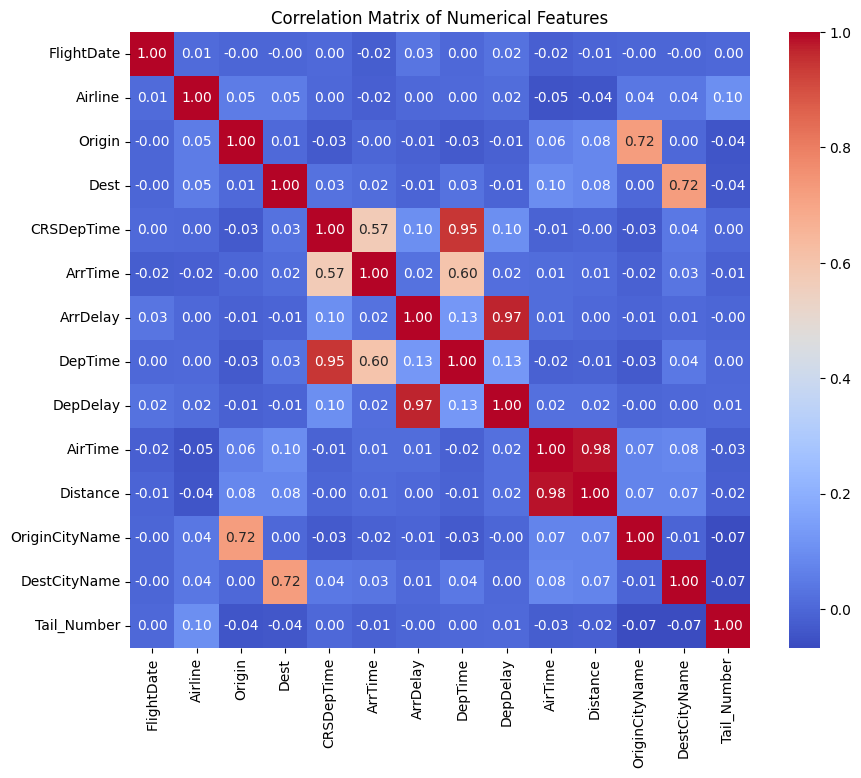

In [ ]:
correlation_matrix = encoded_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Correlations between
- Origin City Name / Origin (0.72)
- DestCityName / Dest (0.72)
- DepTime / CRSDepTime (0.95)
- DepTime / ArrTime (0.60)
- DepDelay / ArrDelay (0.97)
- ArrTime / CRSDeptime (0.57)
- Distance / AirTime (0.98)

After looking at the correlation matrix, we see there are some correlations. We want to use other methods to see if we get similar results, i.e. PCA

## PCA & KMeans

We explored PCA to see if we can perform dimensional reduction and still have a lot of the variance of the data preserved. We used the `explained_variance_ratio` to see which principal components capture ~95% of the original data.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Either load in cleaned_flights_df or make a copy
pca_df = pd.read_csv('cleaned_flights_df.csv', index_col=0)
# pca_df = encoded_df.copy()

# select numerical features for PCA
numerical_features = pca_df.select_dtypes(include=np.number)

# Apply PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(numerical_features)

# Add PCA results to df
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_result, columns=pca_columns, index=pca_df.index)

explained variance ratio: [0.70747501 0.15440854 0.08709952 0.03534889 0.00437577]


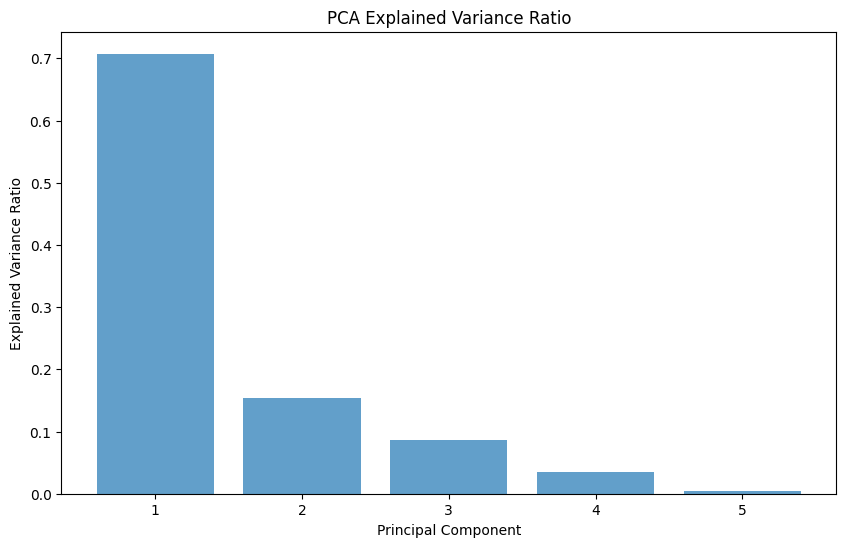

Principal Components:

Principal Component 1:
  Tail_Number: 0.9999325580211634

Principal Component 2:
  DepTime: 0.601648644838062

Principal Component 3:
  Distance: 0.9926997871969623

Principal Component 4:
  ArrTime: 0.8311440366318115

Principal Component 5:
  DestCityName: 0.5193546103063331


In [ ]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("explained variance ratio:", explained_variance_ratio)
# creating a bar plot of explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('PCA Explained Variance Ratio')
plt.show()

# determinint principal components
principal_components = pca.components_

# print(principal_components)
print("Principal Components:")


feature_names = numerical_features.columns
for i in range(min(5, len(principal_components))):
    component = principal_components[i]
    top_features_indices = np.argsort(np.abs(component))[::-1][:1]
    top_features = [feature_names[j] for j in top_features_indices]
    print(f"\nPrincipal Component {i+1}:")
    for feature_index in top_features_indices:
      print(f"  {feature_names[feature_index]}: {component[feature_index]}")

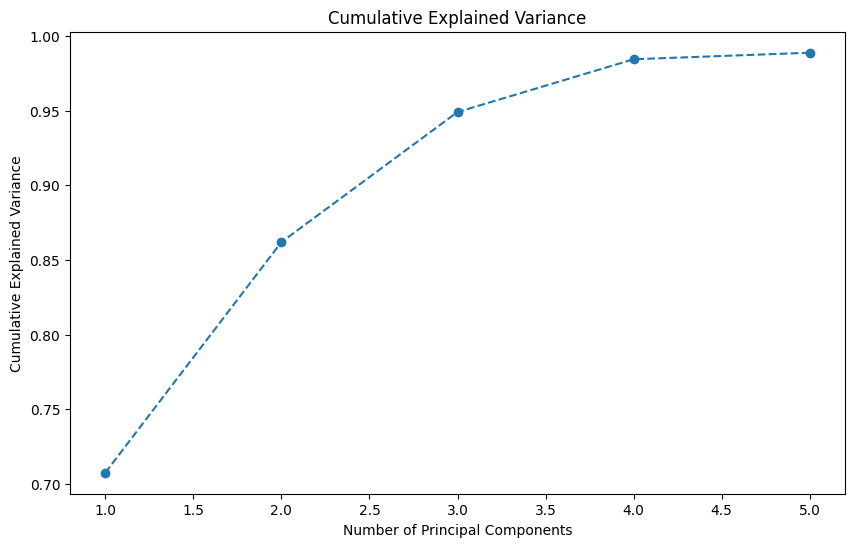

In [ ]:
# getting cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.title('Cumulative Explained Variance')
plt.show()

The two plots above show us that Principal Component 1 explains about 70% of the variance in our data. Cumulatively, the first three principal components explain about 95% of the data. Next, we get the dataset features and their principal component loadings to better understand the contribution of each feature to the principal components.

In [ ]:
loadings_df = pd.DataFrame({
    "Feature": feature_names,
    "PC1": principal_components[0],
    "PC2": principal_components[1]
})

loadings_df

,Feature,PC1,PC2
0,FlightDate,0.000042,-0.000511
1,Airline,0.000379,-0.000036
2,Origin,-0.002528,-0.003356
3,Dest,-0.002529,0.003137
4,CRSDepTime,-0.000003,0.574673
5,ArrTime,-0.005153,0.554601
6,ArrDelay,-0.000056,0.006558
7,DepTime,0.000398,0.601649
8,DepDelay,0.000223,0.006056
9,AirTime,-0.001168,-0.000778


Principal components represent the weighted sum of the feature loadings. From the table above, we observe that PC1 is heavily influenced by Tail Number, indicating that individual planes may contribute to variance within the dataset.

PC2 is influenced by variables like CRSDepTime, ArrTime, and DepTime, indicating that the scheduled departure times and arrival times also contribute to variance in the dataset.

Next, we run kmeans over these pca results and visualize the effects. The use of kmeans here is justified as it can group similar data points that share common patterns in the most important features. Now that we have identified the leading principal components, kmeans allows us to see how the data varies along these components, providing insights into their separability and what features contribute to the individual groups.

In [ ]:
from sklearn.cluster import KMeans

# running kmeans on pca results
kmeans = KMeans(n_clusters=2, n_init=10, random_state=111)
kmeans_labels = kmeans.fit_predict(pca_result)

pca_df['Cluster'] = kmeans_labels

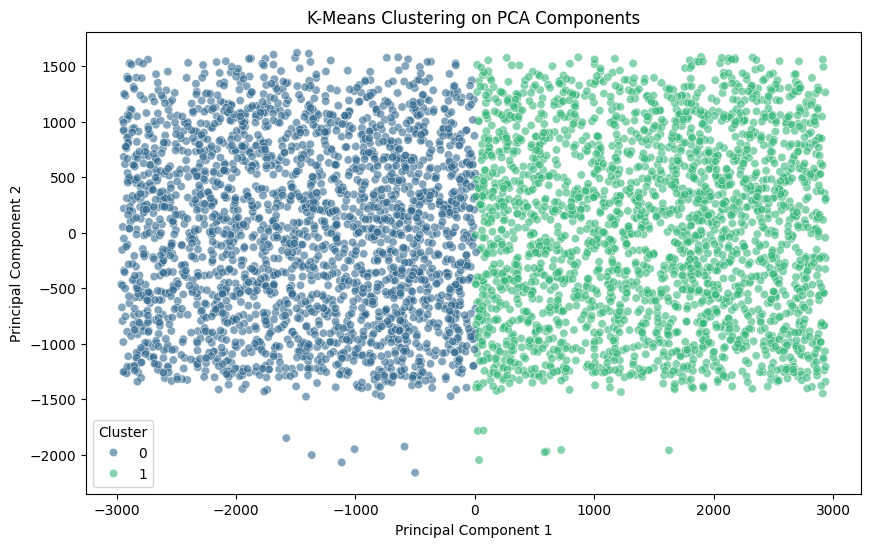

In [ ]:
# sampling a small subset of the data
pca_df_sampled = pca_df.sample(n=5000, random_state=111)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_sampled, x='PC1', y='PC2', hue='Cluster', palette='viridis', alpha=0.6)
plt.title('K-Means Clustering on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In this graph, we again see the impact of PC1 in explaining variance. Cluster 1 has lower PC1 scores while Cluster 2 has higher PC1 scores. This perhaps indicates that there are separate groups within our dataset based on individual planes.

# Analysis


After data preprocessing and EDA, we move into trying to solve our initial hypothesis: Can we predict when delays occur?

- Because DepDelay is highly correlated with ArrDelay, we will assume testing on either variable will result in the same outcome. Therefore, arbitrarily, we choose DepDelay. We will perform a variable of experiments with different models.
  - Logistic Regression
  - Random forest classifier
  - XGB Boost

In [ ]:
# Convert DepDelay to a target variable.
analysis_df = pd.read_csv('cleaned_flights_df.csv', index_col=0)
analysis_df = analysis_df.sample(n=100000, random_state=42) # subset of 100,000
# analysis_df = encoded_df.copy()

# Create a subset because we are using a lot of ram processing through this data.
features = analysis_df.drop(columns=['DepDelay'])
target = analysis_df['DepDelay'].map(lambda x: 1 if x > 0 else 0)

DepDelay was binarized, given a value of 1 if there was a positive delay. A 0 otherwise.

1s: delay DepDelay
0    60601
1    39399
Name: count, dtype: int64


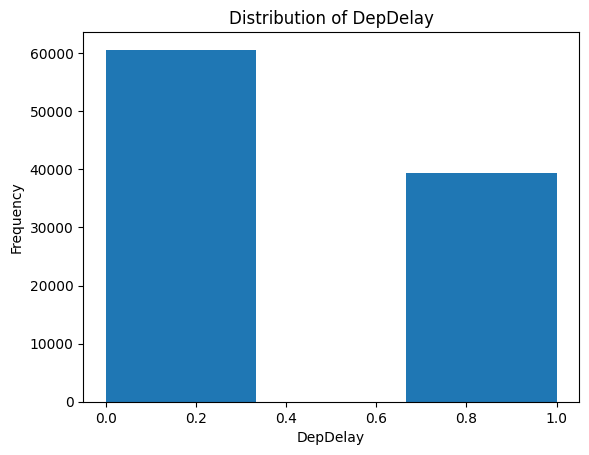

In [ ]:
# Check the distribution of DepDelay. Visualize it
print("1s: delay", target.value_counts())
plt.hist(target, bins=3)
plt.xlabel('DepDelay')
plt.ylabel('Frequency')
plt.title('Distribution of DepDelay')
plt.show()

## Logistic Regression

Our baseline was a logistic regression model. We chose this because it was simple and we could build upon it. Furthermore, logistic regression models are the most commonly used methods to model the probability of an event through maximum likelihood estimations. Since our goal is to predict the event that a flight is delayed, logistic regression models are a natural solution for our problem. Logistic regression models are also interpretable, allowing us to easily analyze model coefficients to determine relative feature importance.

For this model, and all models after, we use the `stratify` parameter in train_test_split to avoid poor results due to the imbalance of our target variable.

For our purposes, we do not want to label a flight as delayed if it is not actually delayed. Imagine a situation where you tell a customer a flight will be delayed so they show up late and the flight is not actually delayed. They could potentially miss their flight which is worse than accidentally showing up for a flight too early. ***Thus, we choose to focus on improving the precision of our model. *** This is because precision minimizes false positives -- flights that are labeled as delayed but are actually on time.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score

In [ ]:
seed = 123
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.20,
                                                    random_state = seed,
                                                    stratify=target)

#train a logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# predicting with lr model
lr_train_predictions = lr_model.predict(X_train)
lr_test_predictions = lr_model.predict(X_test)

# lrg performance metrics
lrg_train_acc = accuracy_score(y_train, lr_train_predictions)
lrg_test_acc = accuracy_score(y_test, lr_test_predictions)

lrg_train_recall = recall_score(y_train, lr_train_predictions)
lrg_test_recall = recall_score(y_test, lr_test_predictions)

lrg_train_precision = precision_score(y_train, lr_train_predictions)
lrg_test_precision = precision_score(y_test, lr_test_predictions)

print(f"Logistic Regression Training Accuracy: {lrg_train_acc}")
print(f"Logistic Regression Testing Accuracy: {lrg_test_acc}")
print(f"Logistic Regression Training Recall: {lrg_train_recall}")
print(f"Logistic Regression Testing Recall: {lrg_test_recall}")
print(f"Logistic Regression Training Precision: {lrg_train_precision}")
print(f"Logistic Regression Testing Precision: {lrg_test_precision}")

Logistic Regression Training Accuracy: 0.82445
Logistic Regression Testing Accuracy: 0.82605
Logistic Regression Training Recall: 0.688314984612456
Logistic Regression Testing Recall: 0.6819796954314721
Logistic Regression Training Precision: 0.8371599459772333
Logistic Regression Testing Precision: 0.8466992279817237


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We obtain 82% accuracy, 68% recall, and 85% precision. While we are focusing on maximizing precision, the recall of this model seems to be quite low. Precision seems to be pretty good at 85%. Since recall and precision come with a tradeoff, improvements on recall may adversely impact precision which potentially explains the recall-precision dynamics in these results. This will have to be something we monitor in further models and hyperparameter tuning. Ideally, more advanced models will be able to improve upon this recall metric while still retaining high precision (which is our focus). Shown below is a confusion matrix for our model.

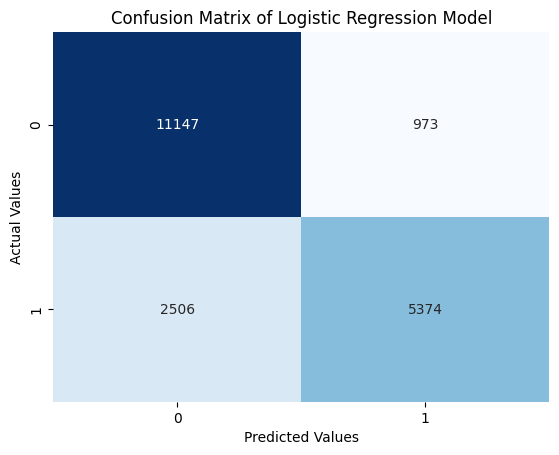

In [ ]:
# confusion matrix for lr model
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, lr_test_predictions)
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=True,
    yticklabels=True
)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix of Logistic Regression Model")
plt.show()

Next, lets extract and visualize the logistic regression coefficients to understand what the most "important" features in our model are. The magnitude of each coefficient tells us how much influence each feature has on the model's prediction, meaning that we can use this magnitude as a proxy for how important each feature is in our model.

In [ ]:
pd.DataFrame({'Features': X_train.columns, 'Coefficient': lr_model.coef_[0]}).sort_values('Coefficient', ascending=False).reset_index(drop=True)


,Features,Coefficient
0,ArrDelay,0.105393
1,Airline,0.039074
2,Distance,0.005093
3,DepTime,0.003190
4,Dest,0.000949
5,ArrTime,0.000103
6,Tail_Number,0.000039
7,FlightDate,0.000023
8,OriginCityName,-0.000142
9,Origin,-0.001020


In [ ]:
# feature magnitudes from lr model
lrg_coefs = np.abs(lr_model.coef_[0])
feature_vals = pd.DataFrame({'Features': X_train.columns, 'Magnitude': lrg_coefs}).sort_values('Magnitude', ascending=False).reset_index(drop=True)
feature_vals

,Features,Magnitude
0,ArrDelay,0.105393
1,AirTime,0.040021
2,Airline,0.039074
3,Distance,0.005093
4,DepTime,0.003190
5,CRSDepTime,0.002752
6,DestCityName,0.001327
7,Origin,0.001020
8,Dest,0.000949
9,OriginCityName,0.000142


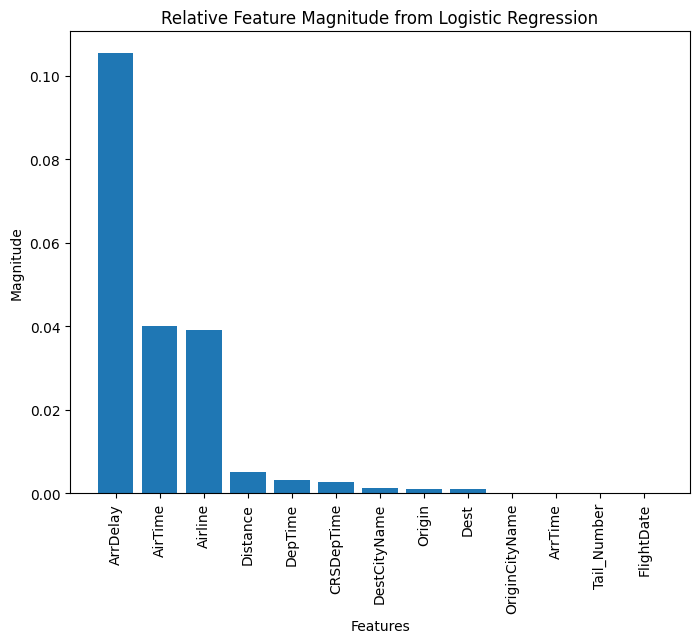

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(feature_vals.Features, feature_vals.Magnitude)
plt.title('Relative Feature Magnitude from Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Magnitude')
plt.xticks(rotation=90)
plt.show()

We observe that features like "ArrDelay", "AirTime", "Airline", "Distance", and "CRSDepTime" have higher relative importance in our model. More specifically, these features are useful in predicting whether or not a flight will be delayed. If a flight arrived late, it is more likely that the departure flight was delayed. Flights with longer air times are less likely to be delayed.

Thus far, we have established our baseline logistic regression model, giving us performance metrics to compare the rest of our models on. Again, we want to focus on maximizing precision.

### Logistic Regression Hyperparameter Tuning

For hyperparameter tuning, we focus on experimenting with 4 main parameters:
*   solver: The algorithm used to optimize our model. We experimented with a mix of solvers, each differentially suited for large vs small datasets, different types of regularization, and different types of classification problems.
*   C: Inverse regularization strength. Larger values result in less regularization, while smaller values apply stronger regularization which may be useful in preventing overfitting.
*   class_weight: Handles imbalanced classes. Our data has a class imbalance so we only set this parameter to balanced.
*   penalty: Defines the regularizaition method (essentially how the coefficients are penalized)

We emphasize precision as our scoring metric to minimize false positives as previously described.


In [ ]:
# defining rfc
estimator_lrg = LogisticRegression(random_state = seed)

# defining the parameter grid
param_grid_lrg = {
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
    'C': [0.25, 0.50, 0.75, 1.0],
    'class_weight': ['balanced'],
    'penalty' : ['l1', 'l2', 'elasticnet'],
}

# defining the metric. Precision because we want to minimize false positives
scoring = 'precision'

We utilize RandomizedSearchCV for all of our hyperparameter tuning purposes. These processes are computationally expensive (especially for Random Forest and large datasets in general), so RandomizedSearchCV is useful as it does not explore every combination of hyperparameters.

In [ ]:
# setting up the grid search for Logistic Regression
search_lrg = RandomizedSearchCV(estimator_lrg, param_grid_lrg, cv=3, scoring=scoring, verbose=2, random_state = seed)

# executing grid search for Logistic Regression
search_lrg.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, penalty=l2, solver=sag; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, penalty=l2, solver=sag; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, penalty=l2, solver=sag; total time=   2.9s
[CV] END C=0.5, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.75, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.75, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.75, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.75, class_weight=balanced, penalty=l2, solver=saga; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.75, class_weight=balanced, penalty=l2, solver=saga; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.75, class_weight=balanced, penalty=l2, solver=saga; total time=   2.6s
[CV] END C=0.25, class_weight=balanced, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.25, class_weight=balanced, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.25, class_weight=balanced, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   1.1s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   1.1s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=saga; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=saga; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=saga; total time=   3.1s
[CV] END C=0.25, class_weight=balanced, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.25, class_weight=balanced, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.25, class_weight=balanced, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.25, class_weight=balanced, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.25, class_weight=balanced, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.25, class_weight=balanced, penalty=elasticnet, solver=saga; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.25, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.25, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Tracebac

[CV] END C=0.25, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.7s


RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=123),
                   param_distributions={'C': [0.25, 0.5, 0.75, 1.0],
                                        'class_weight': ['balanced'],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['liblinear', 'lbfgs', 'sag',
                                                   'saga']},
                   random_state=123, scoring='precision', verbose=2)

### Training the Best Logistic Regression Model with RandomizedSearchCV

In [ ]:
best_model_lrg = search_lrg.best_estimator_
print(best_model_lrg)
y_pred_best_lrg = best_model_lrg.predict(X_test)

accuracy_best_lrg = accuracy_score(y_test, y_pred_best_lrg)
recall_best_lrg = recall_score(y_test, y_pred_best_lrg)
precision_best_lrg = precision_score(y_test, y_pred_best_lrg)

print(f"Accuracy: {accuracy_best_lrg}")
print(f"Recall: {recall_best_lrg}")
print(f"Precision: {precision_best_lrg}")

LogisticRegression(class_weight='balanced', random_state=123,
                   solver='liblinear')
Accuracy: 0.82565
Recall: 0.7567258883248731
Precision: 0.7915836983937342


We specified precision as the metric to focus on in our grid search methodology. We see that our hyperparameter tuning did not significantly impact accuracy. We see decreased precision and gains in recall as expected. We next turn to Random Forest Classifiers to attempt to further improve upon our logistic regression baselines.

## Random Forest Classifiers

Random Forest Classifier use bagging and we thought it was a good idea to have an ensemble of decision trees to improve upon the baseline metrics obtained from logistic regression.

Random Forest Classifiers are powerful as they involve aggregating the classifications of many estimators (trees). Single estimators are easily overfit and may have large variance which can negatively impact prediction error. To reduce prediction error, you can instead take the average of different, uncorrelated prediction equations which is where Random Forest comes in. Each tree is automatically built on randomly selected variables to ensure that trees are not correlated with each other. One limitation is that this process of building random trees and bagging their predictions means that you cannot simply intepret the prediction equation. Furthermore, you introduce complexity in the form of tuning parameters.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(random_state=seed, n_estimators = 50, max_depth = 15)

In [ ]:
# Train the model
rfc.fit(X_train, y_train)

# predict with rfc
rfc_train_pred = rfc.predict(X_train)
rfc_test_pred = rfc.predict(X_test)

# performance metrics for rfc
rfc_train_acc = accuracy_score(y_train, rfc_train_pred)
rfc_test_acc = accuracy_score(y_test, rfc_test_pred)

rfc_train_recall = recall_score(y_train, rfc_train_pred)
rfc_test_recall = recall_score(y_test, rfc_test_pred)

rfc_train_precision = precision_score(y_train, rfc_train_pred)
rfc_test_precision = precision_score(y_test, rfc_test_pred)

# Output results
print(f"Random Forest Training Accuracy: {rfc_train_acc}")
print(f"Random Forest Testing Accuracy: {rfc_test_acc}")
print(f"Random Forest Training Recall: {rfc_train_recall}")
print(f"Random Forest Testing Recall: {rfc_test_recall}")
print(f"Random Forest Training Precision: {rfc_train_precision}")
print(f"Random Forest Testing Precision: {rfc_test_precision}")

Random Forest Training Accuracy: 0.913725
Random Forest Testing Accuracy: 0.83355
Random Forest Training Recall: 0.8297852089216028
Random Forest Testing Recall: 0.7211928934010152
Random Forest Training Precision: 0.9444946011339425
Random Forest Testing Precision: 0.8338958180484226


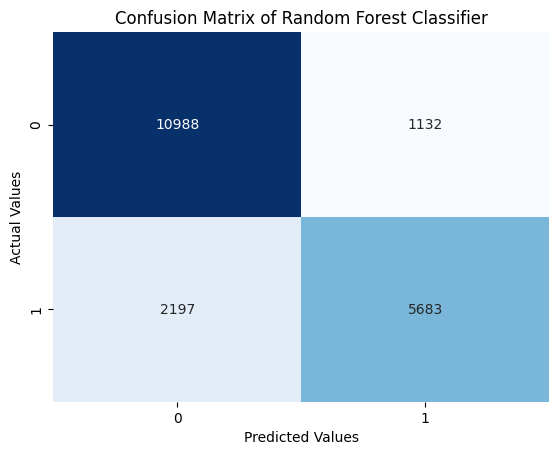

In [ ]:
conf_matrix_rfc = confusion_matrix(y_test, rfc_test_pred)
sns.heatmap(
    conf_matrix_rfc,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=True,
    yticklabels=True
)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix of Random Forest Classifier")
plt.show()

### Random Forest Hyperparameter Tuning

We observe 83% accuracy, 72% recall, and 83% precision. We will utilize hyperparameter tuning to attempt to improve upon these metrics.

For hyperparameter tuning, we focus on experimenting with the following parameters:

*  n_estimators: The number of trees in the forest. More trees may improve results and reduce prediction error, but computational time suffers.
*  max_depth: The maximum depth of each decision tree. Deeper trees may capture more details about the data but can result in overfitting.
*  class_weight: Handles imbalanced classes. Our data has a class imbalance so we only set this parameter to balanced.

We emphasize precision as our scoring metric to minimize false positives as previously described.

In [ ]:
# Define parameter grid
rfc_param_grid = {'n_estimators': [50, 100, 150, 200],
              'max_depth': [10, 15, 20, 25],
              'class_weight': ['balanced'],
              'random_state': [seed]}

random_forest_model = RandomForestClassifier(random_state = seed)
rfc_grid_search = RandomizedSearchCV(random_forest_model, rfc_param_grid, cv=3, scoring='precision', verbose=True, random_state = seed)
results = rfc_grid_search.fit(X_train, y_train)

# Print the best parameters and cross validation score
print("Best Parameters:", rfc_grid_search.best_params_)
print("Best Cross Validation Score:", rfc_grid_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'random_state': 123, 'n_estimators': 200, 'max_depth': 20, 'class_weight': 'balanced'}
Best Cross Validation Score: 0.8301580910039134


We tuned parameters such as the number of the estimators, the maximum tree depth, and the class balancing strategy. By evaluating it using the 3-fold cross-validation, this method gives a reliable assessment of each hyperparameter combination (reducing overfitting/underfitting).

### Training the best model from Grid Search

In [ ]:
best_model_rfc = rfc_grid_search.best_estimator_
print(best_model_rfc)
y_pred_best = best_model_rfc.predict(X_test)

accuracy_best_rfc = accuracy_score(y_test, y_pred_best)
recall_best_rfc = recall_score(y_test, y_pred_best)
precision_best_rfc = precision_score(y_test, y_pred_best)

print(f"Accuracy: {accuracy_best_rfc}")
print(f"Recall: {recall_best_rfc}")
print(f"Precision: {precision_best_rfc}")

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=200,
                       random_state=123)
Accuracy: 0.83885
Recall: 0.7517766497461928
Precision: 0.8238075371992769


Our optimal parameters are a max depth of 20 and 200 estimators. This hyperparameter tuning led to incremental gains in accuracy (84%) and recall (74%), but not precision (82%). Ideally, we want to achieve higher precision as our goal is to minimize false positives. Random forest and logistic regression methods thus far seem unable to increase both precision and recall (one seems to come at the expense of the other), so we turn to the XGBoost algorithm to attempt to improve upon this metric while not penalizing performance in recall or accuracy.

## XGBoost

We'll use XGBoost to perform classification and regression tasks by tuning parameters to optimize the model for this binary classification task.

XGBoost provides a scalable tree bossting solution that is capable of handling large dataset. It is an extension on gradient boosting machines that builds an ensemble of weak learners. This process is sequential, meaning that the misclassified predictions of the former learner carry higher penalties in the construction of downstream learners. We believe XGBoost will provide an effective solution to our task as the algorithm is known for its performance in research and industry.

In [ ]:
from xgboost import XGBClassifier

# adjusting class ratio based on our data
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

#initialize and fit xgb classifier
xgb_clf = XGBClassifier(random_state=seed, tree_method='hist', scale_pos_weight=class_ratio, n_estimators=50)
xgb_clf.fit(X_train, y_train)

# predicting with xgb classifier
xgb_clf_y_train_pred = xgb_clf.predict(X_train)
xgb_clf_y_test_pred = xgb_clf.predict(X_test)

# performance metrics
xgb_train_acc = accuracy_score(y_train, xgb_clf_y_train_pred)
xgb_test_acc = accuracy_score(y_test, xgb_clf_y_test_pred)

xgb_train_recall = recall_score(y_train, xgb_clf_y_train_pred)
xgb_test_recall = recall_score(y_test, xgb_clf_y_test_pred)

xgb_train_precision = precision_score(y_train, xgb_clf_y_train_pred)
xgb_test_precision = precision_score(y_test, xgb_clf_y_test_pred)

print(f"XGBoost Training Accuracy: {xgb_train_acc}")
print(f"XGBoost Testing Accuracy: {xgb_test_acc}")
print(f"XGBoost Training Recall: {xgb_train_recall}")
print(f"XGBoost Testing Recall: {xgb_test_recall}")
print(f"XGBoost Training Precision: {xgb_train_precision}")
print(f"XGBoost Testing Precision: {xgb_test_precision}")

XGBoost Training Accuracy: 0.906275
XGBoost Testing Accuracy: 0.8856
XGBoost Training Recall: 0.8843871950252229
XGBoost Testing Recall: 0.8554568527918782
XGBoost Training Precision: 0.87853383340162
XGBoost Testing Precision: 0.8543726235741445


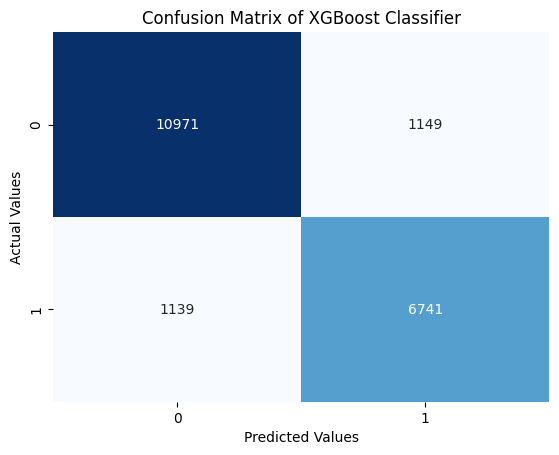

In [ ]:
conf_matrix_xgb = confusion_matrix(y_test, xgb_clf_y_test_pred)
sns.heatmap(
    conf_matrix_xgb,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=True,
    yticklabels=True
)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix of XGBoost Classifier")
plt.show()

Our intial XGBoost model achieves an accuracy of 89%, recall of 86%, and precision of 85%. So far, this is our best performing model. We are  able to obtain maximal precision, while also maintaing high recall (unlike the logistic regression model for example). Additionally, we do not see high dropoffs between training and testing metrics, indicating that we are not overfitting.

### XGBoost Hyperparameter Tuning

For hyperparameter tuning the XGBoost algorithm, we focus on experimenting with the following parameters:

*  n_estimators: The number of boosting trees or iterations. Essentially determines how many estimators are built during training.
*  max_depth: The maximum depth of each decision tree. Deeper trees may capture more details about the data but can result in overfitting.
*  learning_rate: Shrinking parameter to determine how much each tree contributes to the final prediction. Helps avoid overfitting, balances training speed and accuracy.

We emphasize precision as our scoring metric to minimize false positives as previously described.

In [ ]:
# Define parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15]
}

xgb_gs = XGBClassifier(random_state = seed)
grid_search_xgb = RandomizedSearchCV(xgb_gs, param_grid_xgb, cv=3, scoring='precision', verbose=True, random_state = seed)
results = grid_search_xgb.fit(X_train, y_train)

# Print the best parameters and cross validation score
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Cross Validation Score:", grid_search_xgb.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2}
Best Cross Validation Score: 0.9439030191480416


### Training the best XGB Model

In [ ]:
best_model_xgb = grid_search_xgb.best_estimator_
print(best_model_xgb)
y_pred_best_xgb = best_model_xgb.predict(X_test)

accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
recall_best_xgb = recall_score(y_test, y_pred_best_xgb)
precision_best_xgb = precision_score(y_test, y_pred_best_xgb)

print(f"Accuracy: {accuracy_best_xgb}")
print(f"Recall: {recall_best_xgb}")
print(f"Precision: {precision_best_xgb}")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)
Accuracy: 0.9422
Recall: 0.8964467005076142
Precision: 0.9540788762830902


After hyperparameter tuning, our XGBoost Classifier obtains impressive results. We see accuracy of 94%, recall of 90%, and precision of 95%. We see that a higher learning rate (0.2), more estimators (200), and medium max depth (10) seem to contribute positively to our performance numbers.

## Summary and Comparison of Models

Shown below are tabular summaries of the performance of each model for both the base model and the hyperparameter tuned models. Again, precision was the metric that we wanted to maximize, although we also wanted to ensure that this did not come at the expense of either recall or accuracy.

In [ ]:
tuned_data = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Precision": [precision_best_lrg, precision_best_rfc, precision_best_xgb],
    "Recall": [recall_best_lrg, recall_best_rfc, recall_best_xgb],
    "Accuracy": [accuracy_best_lrg, accuracy_best_rfc, accuracy_best_xgb]
}

untuned_data = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Precision": [lrg_test_precision, rfc_test_precision, xgb_test_precision],
    "Recall": [lrg_test_recall, rfc_test_recall, xgb_test_recall],
    "Accuracy": [lrg_test_acc, rfc_test_acc, xgb_test_acc]
}

df_tuned = pd.DataFrame(tuned_data)
df_untuned = pd.DataFrame(untuned_data)

In [ ]:
df_untuned

,Model,Precision,Recall,Accuracy
0,Logistic Regression,0.846699,0.681980,0.82605
1,Random Forest,0.833896,0.721193,0.83355
2,XGBoost,0.854373,0.855457,0.88560


In [ ]:
df_tuned

,Model,Precision,Recall,Accuracy
0,Logistic Regression,0.791584,0.756726,0.82565
1,Random Forest,0.823808,0.751777,0.83885
2,XGBoost,0.954079,0.896447,0.94220


Next, we create bar charts of the tuned and untuned models to visualize their performance metrics.

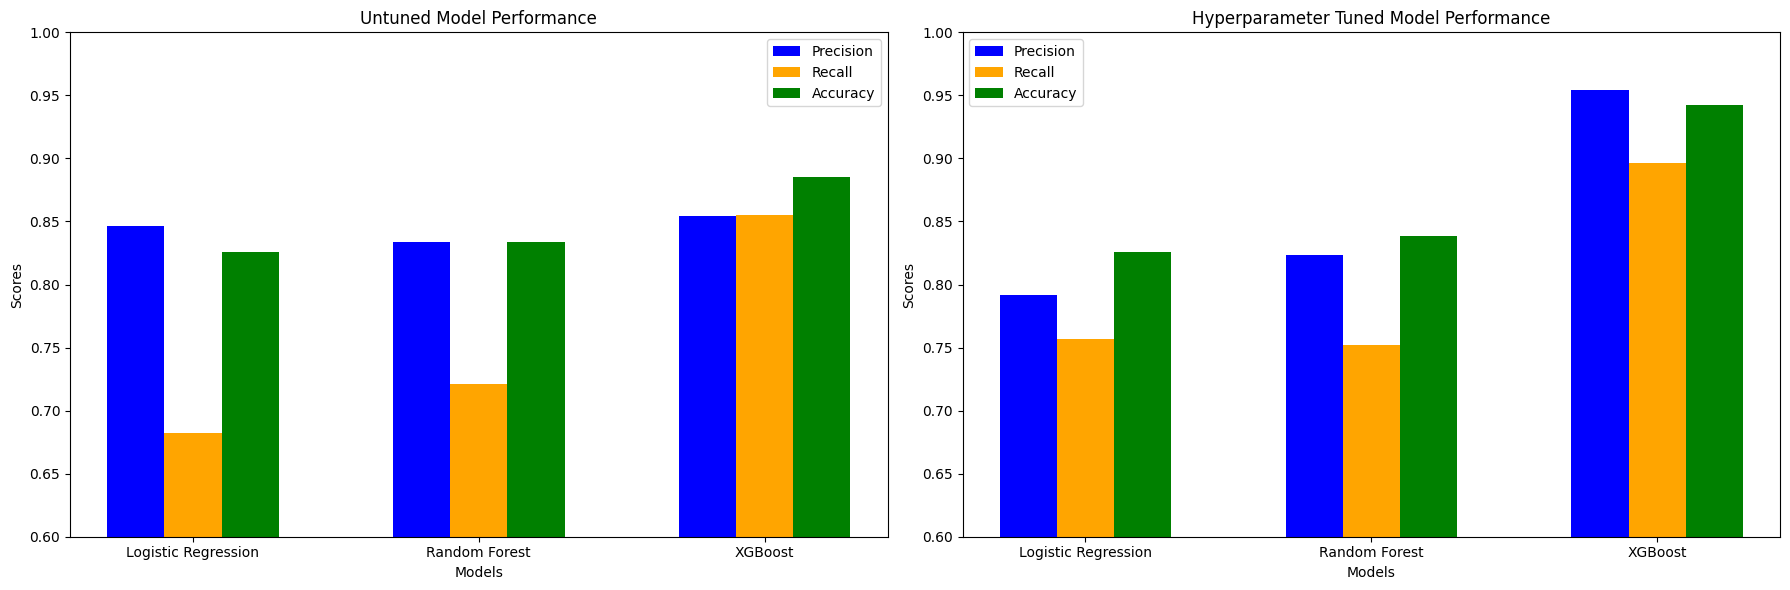

In [ ]:
# Plotting performance of tuned models
models_tuned = df_tuned["Model"]
precisions_tuned = df_tuned["Precision"]
recalls_tuned = df_tuned["Recall"]
accuracies_tuned = df_tuned["Accuracy"]

# Plotting performance of untuned models
models_untuned = df_untuned["Model"]
precisions_untuned = df_untuned["Precision"]
recalls_untuned = df_untuned["Recall"]
accuracies_untuned = df_untuned["Accuracy"]

x_tuned = np.arange(len(models_tuned))
x_untuned = np.arange(len(models_untuned))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

width = 0.2
ax1.bar(x_untuned - width, precisions_untuned, width, label='Precision', color='blue')
ax1.bar(x_untuned, recalls_untuned, width, label='Recall', color='orange')
ax1.bar(x_untuned + width, accuracies_untuned, width, label='Accuracy', color='green')

ax1.set_xlabel("Models")
ax1.set_ylabel("Scores")
ax1.set_title("Untuned Model Performance")
ax1.set_xticks(x_untuned)
ax1.set_xticklabels(models_untuned)
ax1.set_ylim(0.6, 1.0)
ax1.legend()

ax2.bar(x_tuned - width, precisions_tuned, width, label='Precision', color='blue')
ax2.bar(x_tuned, recalls_tuned, width, label='Recall', color='orange')
ax2.bar(x_tuned + width, accuracies_tuned, width, label='Accuracy', color='green')

ax2.set_xlabel("Models")
ax2.set_ylabel("Scores")
ax2.set_title("Hyperparameter Tuned Model Performance")
ax2.set_xticks(x_tuned)
ax2.set_xticklabels(models_tuned)
ax2.set_ylim(0.6, 1.0)
ax2.legend()

plt.tight_layout()
plt.show()

We observe a few trends in these charts. First, we see that hyperparmeter tuning generally increased model performance in most cases. For the logistic regression model, hyperparameter tuning did not have a large impact on accuracy but it helped balance the precision vs recall tradeoff much better. However, this was not ideal as our end goal was to maximize precision.

The untuned random forest model achieved comparable metrics to the untuned logistic regression model, with improved recall. Tuning the random forest model only provided marginal gains across the three metrics and performed quite similarly overall to the tuned logistic regression model.

Our untuned XGBoost model outperformed even the tuned logistic regression and random forest models, highlighting the merits of gradient boosting mechanisms. Tuning the XGBoost model led to major improvements, making it our best model overall. Furthermore, this tuned XGBoost model had precision as its best metric which is the best outcome for our use case. Additionally, recall and accuracy are also the highest out of all models, meaning we effectively balanced and optimized every metric by utilizing the XGBoost algorithm.


Finally, we create radar charts to provide a more dynamic look at how hyperparameter tuning impacted our model performance.

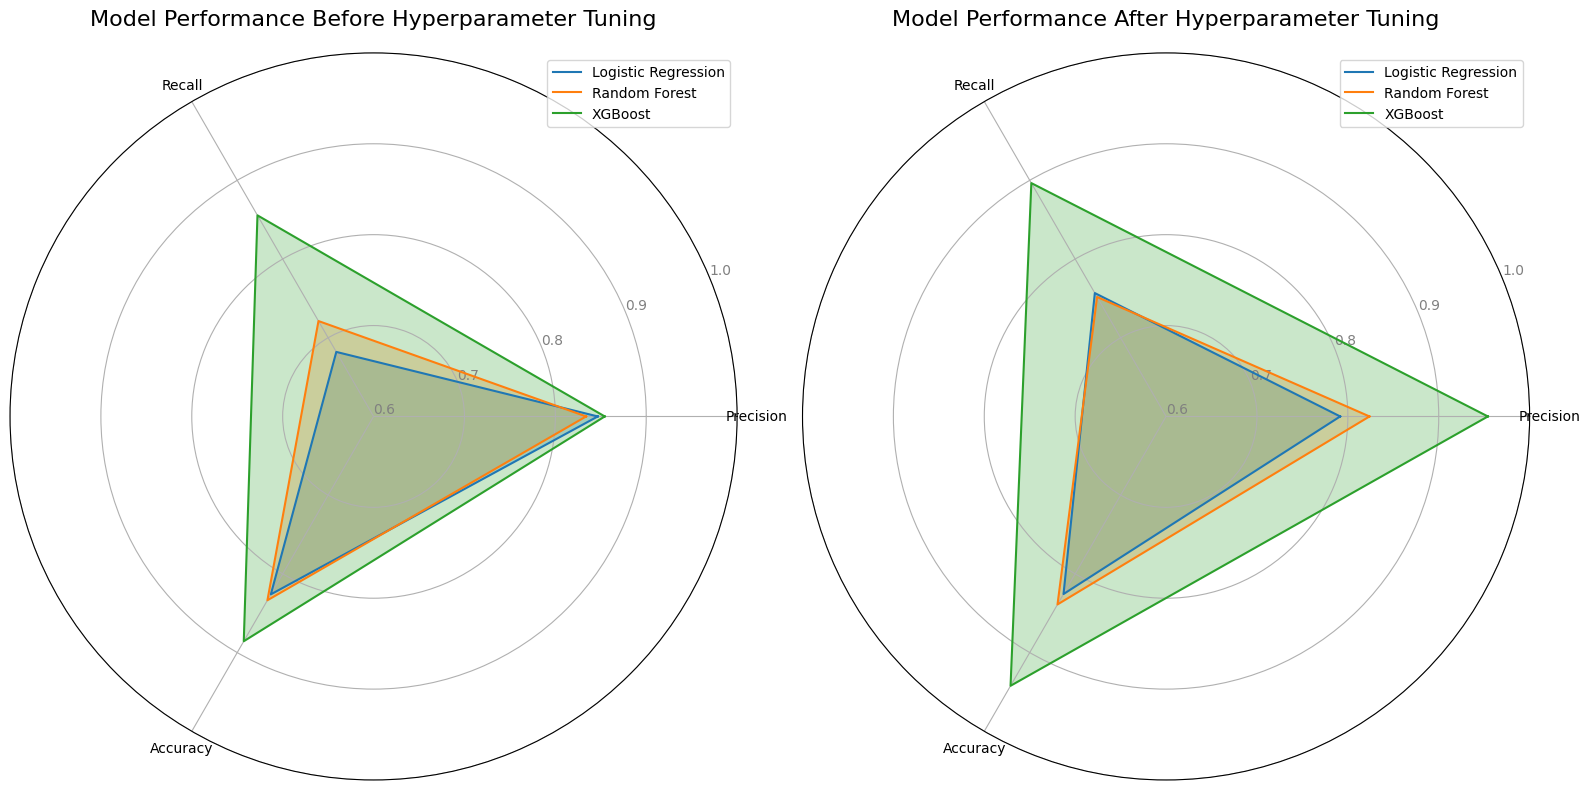

In [ ]:
from math import pi

# Radar chart before hyperparameter tuning
categories_untuned = df_untuned.columns[1:]
num_vars_untuned = len(categories_untuned)

angles_untuned = [n / float(num_vars_untuned) * 2 * pi for n in range(num_vars_untuned)]
angles_untuned += angles_untuned[:1]

# Radar chart after hyperparameter tuning
categories_tuned = df_tuned.columns[1:]
num_vars_tuned = len(categories_tuned)

angles_tuned = [n / float(num_vars_tuned) * 2 * pi for n in range(num_vars_tuned)]
angles_tuned += angles_tuned[:1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'polar': True})

for i, row in df_untuned.iterrows():
    values_untuned = row[categories_untuned].values.tolist()
    values_untuned += values_untuned[:1]
    ax1.plot(angles_untuned, values_untuned, label=row["Model"])
    ax1.fill(angles_untuned, values_untuned, alpha=0.25)

ax1.set_xticks(angles_untuned[:-1])
ax1.set_xticklabels(categories_untuned)
ax1.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
ax1.set_yticklabels(['0.6', '0.7', '0.8', '0.9', '1.0'], color="grey", size=10)
ax1.set_ylim(0.6, 1.0)
ax1.set_title("Model Performance Before Hyperparameter Tuning", size=16, pad=20)
ax1.legend(loc='upper right')

for i, row in df_tuned.iterrows():
    values_tuned = row[categories_tuned].values.tolist()
    values_tuned += values_tuned[:1]
    ax2.plot(angles_tuned, values_tuned, label=row["Model"])
    ax2.fill(angles_tuned, values_tuned, alpha=0.25)

ax2.set_xticks(angles_tuned[:-1])
ax2.set_xticklabels(categories_tuned)
ax2.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
ax2.set_yticklabels(['0.6','0.7', '0.8', '0.9', '1.0'], color="grey", size=10)
ax2.set_ylim(0.6, 1.0)
ax2.set_title("Model Performance After Hyperparameter Tuning", size=16, pad=20)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

These plots illustrate many of the points that we previously mentioned, although in a different graphical format. Visualizing model performance in this manner makes it easy to see that the XGBoost model is the most "well-rounded" in respect to how it maximized each scoring metric over all of the other models.

# Hypothesis Testing

After looking and different models for delay predictions, we shift to hypothesis testing. For example, our null hypothesis could assume that the average delay time t is the same across all airports. By grouping flights by airport and calculating each airport’s average delay, we can identify whether certain airports show statistically significant differences by comparing their average delay times against this threshold, identifying those consistently above or below the overall delay level.

In [ ]:
testing_df = analysis_df.copy().reset_index().dropna(subset=['DepDelay'])
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           100000 non-null  int64  
 1   FlightDate      100000 non-null  int64  
 2   Airline         100000 non-null  int64  
 3   Origin          100000 non-null  int64  
 4   Dest            100000 non-null  int64  
 5   CRSDepTime      100000 non-null  int64  
 6   ArrTime         100000 non-null  float64
 7   ArrDelay        100000 non-null  float64
 8   DepTime         100000 non-null  float64
 9   DepDelay        100000 non-null  float64
 10  AirTime         100000 non-null  float64
 11  Distance        100000 non-null  float64
 12  OriginCityName  100000 non-null  int64  
 13  DestCityName    100000 non-null  int64  
 14  Tail_Number     100000 non-null  int64  
dtypes: float64(6), int64(9)
memory usage: 11.4 MB


#### Imagine you are a consumer who prefers early morning flights, since you believe that they are less likely to be delayed. In this scenario, the null hypothesis assumed that the average delay time is the same for morning and evening flights.



In [ ]:
flights_temp = testing_df.copy()

# getting morning vs evening delays
morning_flights = flights_temp[(flights_temp['CRSDepTime'] <= 1000) & (flights_temp['CRSDepTime'] >= 500)]['DepDelay']
evening_flights = flights_temp[(flights_temp['CRSDepTime'] >= 1800) & (flights_temp['CRSDepTime'] <= 2300)]['DepDelay']

# observed difference in means
observed_diff = morning_flights.mean() - evening_flights.mean()
combined_delays = np.concatenate([morning_flights, evening_flights])
labels = np.array([0] * len(morning_flights) + [1] * len(evening_flights))

In [ ]:
print(morning_flights.mean(), evening_flights.mean())
print("observed diff:", observed_diff)

6.319549253832357 21.080707291038195
observed diff: -14.761158037205838


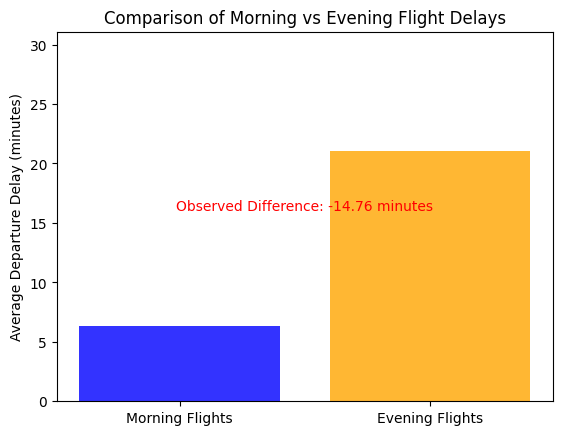

In [ ]:
categories = ['Morning Flights', 'Evening Flights']
means = [morning_flights.mean(), evening_flights.mean()]

plt.bar(categories, means, alpha=0.8, color=['blue', 'orange'])
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Comparison of Morning vs Evening Flight Delays')
plt.ylim(0, max(means) + 10)
observed_diff_text = f"Observed Difference: {observed_diff:.2f} minutes"
plt.text(0.5, max(means) - 5, observed_diff_text, ha='center', fontsize=10, color='red')
plt.show()

In [ ]:
n_permutations = 1000
perm_diffs = np.zeros(n_permutations)

# permutation testing
for i in range(n_permutations):
    shuffled_labels = np.random.permutation(labels)
    morning_mean = combined_delays[shuffled_labels == 0].mean()
    evening_mean = combined_delays[shuffled_labels == 1].mean()
    perm_diffs[i] = morning_mean - evening_mean

p_value = (np.abs(perm_diffs) >= np.abs(observed_diff)).mean()

print(f"Observed Difference in Means: {observed_diff}")
print(f"P-value: {p_value}")


Observed Difference in Means: -14.761158037205838
P-value: 0.0


By performing a permutation test, we observed a significant difference in mean delays, with morning flights having (on average), a 14.76 minute shorter delay compared to evening flights.

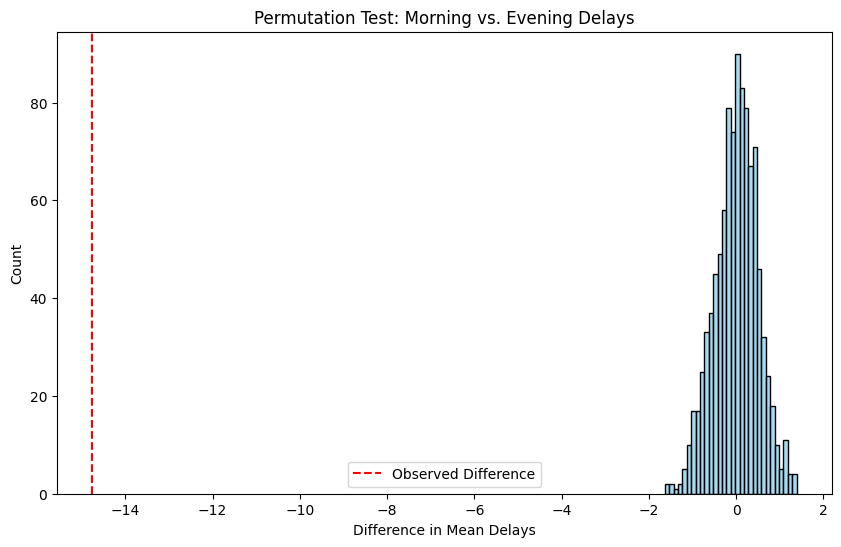

In [ ]:
# Plot the hypothesis testing to the normal statistic
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(perm_diffs, bins=30,color='skyblue')
plt.axvline(observed_diff, color='red', linestyle='--', label='Observed Difference')
plt.title('Permutation Test: Morning vs. Evening Delays')
plt.xlabel('Difference in Mean Delays')
plt.legend()
plt.show()

# Conclusion

Overall, we explored the Flight Status Prediction dataset to understand and model factors contributing to flight delays. Using various machine learning approaches, including Random Forest and XGBoost, we achieved notable predictive performance, with XGBoost delivering the highest accuracy of approximately 94% and precision of 95%. Grid Search optimization further refined our models, demonstrating the importance of tuning hyperparameters for improved results.

In addition, we conducted hypothesis testing to uncover significant relationships within the data. For instance, a permutation test revealed that morning flights experience significantly shorter delays compared to evening flights. Another analysis showed a statistically significant positive correlation between flight distance and departure delay.

These findings have provided us with actionable insights into factors influencing flight punctuality, offering potential value for airlines in optimizing scheduling and operations. While our models and analyses effectively leveraged the available data, future work could incorporate external variables like weather and air traffic control data to enhance prediction accuracy and provide a more holistic understanding of delays and cancellations.

# Future Work
In the future, we'd like to implement an ensemble of all the models we created to leverage their individual strengths and improve overall prediction accuracy. We could also explore incorporating external data, such as weather conditions, airport traffic, and airline-specific operational data, to enhance the robustness of our predictions. Additionally, advanced techniques like neural networks or gradient boosting ensembles could be tested to further optimize performance. Finally, deploying the model as a real-time prediction tool for airports and passengers could provide practical applications and insights to improve travel experiences.

# Appendix
Provided below is a description of the features in this dataset

## Feature Descriptions

**Year**: Year  
**Quarter**: Quarter (1-4)  
**Month**: Month  
**DayofMonth**: Day of Month  
**DayOfWeek**: Day of Week  
**FlightDate**: Flight Date (yyyymmdd)  
**Marketing_Airline_Network**: Unique Marketing Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users (e.g., PA, PA(1), PA(2)). Use this field for analysis across a range of years.  
**Operated_or_Branded_Code_Share_Partners**: Reporting Carrier Operated or Branded Code Share Partners  
**DOT_ID_Marketing_Airline**: US DOT-assigned ID to identify a unique airline. A unique airline is defined by the same DOT certificate regardless of code or name.  
**IATA_Code_Marketing_Airline**: IATA code for identifying a carrier (may not always be unique). Use the Unique Carrier Code for analysis.  
**Flight_Number_Marketing_Airline**: Flight Number  
**Originally_Scheduled_Code_Share_Airline**: Unique Scheduled Operating Carrier Code, with numeric suffixes for earlier users of the same code.  
**DOT_ID_Originally_Scheduled_Code_Share_Airline**: US DOT-assigned ID for identifying a unique airline under the same DOT certificate.  
**IATA_Code_Originally_Scheduled_Code_Share_Airline**: IATA-assigned code for carriers (may not be unique). Use Unique Carrier Code for analysis.  
**Flight_Num_Originally_Scheduled_Code_Share_Airline**: Flight Number  
**Operating_Airline**: Unique Carrier Code, with numeric suffixes for earlier users of the same code.  
**DOT_ID_Operating_Airline**: US DOT-assigned ID for unique airlines under the same DOT certificate.  
**IATA_Code_Operating_Airline**: IATA-assigned code for carriers (may not be unique). Use Unique Carrier Code for analysis.  
**Tail_Number**: Tail Number of the aircraft  
**Flight_Number_Operating_Airline**: Flight Number  
**OriginAirportID**: Origin Airport ID (assigned by US DOT). Use for airport analysis across years.  
**OriginAirportSeqID**: Origin Airport Sequence ID for time-specific airport information.  
**OriginCityMarketID**: Origin City Market ID, assigned by US DOT to consolidate airports serving the same city market.  
**Origin**: Origin Airport Code  
**OriginCityName**: Origin Airport City Name  
**OriginState**: Origin Airport State Code  
**OriginStateFips**: Origin Airport State FIPS Code  
**OriginStateName**: Origin Airport State Name  
**OriginWac**: Origin Airport World Area Code  
**DestAirportID**: Destination Airport ID (assigned by US DOT). Use for airport analysis across years.  
**DestAirportSeqID**: Destination Airport Sequence ID for time-specific airport information.  
**DestCityMarketID**: Destination City Market ID, assigned by US DOT to consolidate airports serving the same city market.  
**Dest**: Destination Airport Code  
**DestCityName**: Destination Airport City Name  
**DestState**: Destination Airport State Code  
**DestStateFips**: Destination Airport State FIPS Code  
**DestStateName**: Destination Airport State Name  
**DestWac**: Destination Airport World Area Code  
**CRSDepTime**: Scheduled Departure Time (local time: hhmm)  
**DepTime**: Actual Departure Time (local time: hhmm)  
**DepDelay**: Difference in minutes between scheduled and actual departure time (negative for early departures).  
**DepDelayMinutes**: Difference in minutes between scheduled and actual departure time (early departures set to 0).  
**DepDel15**: Departure Delay Indicator (15 Minutes or More; 1 = Yes)  
**DepartureDelayGroups**: Departure delay intervals (15-minute increments).  
**DepTimeBlk**: Scheduled Departure Time Block (hourly intervals).  
**TaxiOut**: Taxi Out Time (in minutes).  
**WheelsOff**: Wheels Off Time (local time: hhmm).  
**WheelsOn**: Wheels On Time (local time: hhmm).  
**TaxiIn**: Taxi In Time (in minutes).  
**CRSArrTime**: Scheduled Arrival Time (local time: hhmm).  
**ArrTime**: Actual Arrival Time (local time: hhmm).  
**ArrDelay**: Difference in minutes between scheduled and actual arrival time (negative for early arrivals).  
**ArrDelayMinutes**: Difference in minutes between scheduled and actual arrival time (early arrivals set to 0).  
**ArrDel15**: Arrival Delay Indicator (15 Minutes or More; 1 = Yes).  
**ArrivalDelayGroups**: Arrival delay intervals (15-minute increments).  
**ArrTimeBlk**: Scheduled Arrival Time Block (hourly intervals).  
**Cancelled**: Cancelled Flight Indicator (1 = Yes).  
**CancellationCode**: Specifies the reason for cancellation.  
**Diverted**: Diverted Flight Indicator (1 = Yes).  
**CRSElapsedTime**: Scheduled elapsed flight time (in minutes).  
**ActualElapsedTime**: Actual elapsed flight time (in minutes).  
**AirTime**: Flight time (in minutes).  
**Flights**: Number of flights.  
**Distance**: Distance between airports (in miles).  
**DistanceGroup**: Distance intervals (every 250 miles).  
**CarrierDelay**: Carrier delay (in minutes).  
**WeatherDelay**: Weather delay (in minutes).  
**NASDelay**: National Air System delay (in minutes).  
**SecurityDelay**: Security delay (in minutes).  
**LateAircraftDelay**: Late Aircraft delay (in minutes).  
**FirstDepTime**: First gate departure time at origin airport.  
**TotalAddGTime**: Total ground time away from gate for gate return or cancelled flight.  
**LongestAddGTime**: Longest time away from gate for gate return or cancelled flight.  
**DivAirportLandings**: Number of diverted airport landings.  
**DivReachedDest**: Diverted flight reaching scheduled destination indicator (1 = Yes).  
**DivActualElapsedTime**: Elapsed time of diverted flight reaching scheduled destination (in minutes).  
**DivArrDelay**: Difference in minutes between scheduled and actual arrival time for a diverted flight.  
**DivDistance**: Distance between scheduled destination and final diverted airport (in miles).  
**Div1Airport to Div5Airport**: Diverted Airport Code (up to 5 diversions).  
**Duplicate**: Duplicate flag (Y if the flight is swapped based on Form-3A data).  
